# 基于改进KFCM算法的股票板块划分研究

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
from math import isnan
from copy import deepcopy
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from skfuzzy.cluster import cmeans
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import mpl
from scipy.stats import norm
from scipy import stats
from sklearn.manifold import TSNE
import seaborn
import jieba
from wordcloud import WordCloud, STOPWORDS
from sklearn import mixture
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.cluster import AgglomerativeClustering
from  sklearn.cluster import DBSCAN
plt.figure(dpi = 600)

### 一些可调整的常量 

In [2]:
# 如果熵值超过0.9，则该特征将被剔除
percent=0.9
# 将所有股票分为4大板块
n = 3
# KFCM算法的指数
m = 1.1
# 每个大板块的小板块划分数目
sub_n = 10
# 小板块KFCM算法的指数
sub_m = [1.5, 1.5, 1.7, 1.8, 1.9]  

## 数据预处理 

In [3]:
def LoadData(filename):
    data = pd.read_excel(filename)
    shares_time = data.index
    data.index = list(np.arange(len(data)))
    data.insert(0, 'time', shares_time)
    data = data.drop([1])
    shares_name = data.iloc[[0]]
    shares_name.drop('time', axis=1, inplace=True)
    shares_ID = list(shares_name.columns)
    shares_name = list(list(shares_name.values)[0])
    shares = pd.DataFrame({'shares_ID': shares_ID, 'shares_name': shares_name})
    data = data.drop([0])
    Time = list(data['time'])
    time_list = []
    for i in Time:
        i = str(i)
        time_list.append(i[:10])
    data.drop('time', axis=1, inplace=True)
    data_value = np.matrix(data.values)
    data_value = data_value.T
    data_value = pd.DataFrame(data_value)
    data_value.columns = time_list
    data2 = pd.concat([shares,data_value], axis=1, ignore_index=True)
    data2.columns = list(shares.columns) + time_list
    data.index = list(np.arange(len(data)))
    return data, data2, shares_ID

In [4]:
warnings.filterwarnings("ignore")
filename = '../data/附件.xlsx'
data, shares, shares_ID = LoadData(filename)
shares.to_csv('../data/shares.csv', index=False)
ID_name = shares[['shares_ID', 'shares_name']]
# 将股票ID与股票的名称进行保存，后边绘制词云模型时使用，使用encoding='utf_8_sig'可以解决中文保存乱码的问题
ID_name.to_csv('../result/ID_name.csv', index=False, encoding='utf_8_sig')
shares.head(10)

shares_ID shares_name 2010-01-04 2010-01-05 2010-01-06 2010-01-07  \
0  000001.SZ        平安银行     7.8803    7.74404    7.61109      7.528   
1  000002.SZ         万科A    8.23257    8.04617    8.04617    7.98403   
2  000006.SZ        深振业A    3.58152    3.47845    3.48811    3.45913   
3  000008.SZ        神州高铁    1.39599    1.39599    1.39599    1.39599   
4  000009.SZ        中国宝安    5.69233     5.5453    5.54005    5.64507   
5  000012.SZ         南玻A    7.11215    6.99123    7.20742    6.82634   
6  000021.SZ         深科技    8.03569    8.21972    8.16451    8.26879   
7  000025.SZ         特力A      11.19      11.21      11.32      11.05   
8  000027.SZ        深圳能源    6.14895    6.14436    6.13519    5.99763   
9  000028.SZ        国药一致    26.4724    27.1928    27.6155    26.3956   

  2010-01-08 2010-01-11 2010-01-12 2010-01-13    ...     2018-11-19  \
0    7.51138    7.51138    7.46153    6.96631    ...          10.85   
1     8.0384    7.90637     7.9918    7.79764    ...          25.97   
2    3.54287    3.44946    3.60084    3.48489    ...           5.81   
3    1.39599    1.39599    1.39599    1.39599    ...           4.17   
4    5.91813    5.80261    5.94964    5.63457    ...           5.38   
5    6.75306    6.63581    6.90695    6.64313    ...           4.66   
6    8.25652    8.55709    8.70431     8.6491    ...           6.46   
7      11.14      11.43      11.88      11.81    ...          29.39   
8    6.06641    6.12602    6.31402    6.17646    ...           5.66   
9    25.8865     25.339    25.7905    25.8193    ...          46.02   

  2018-11-20 2018-11-21 2018-11-22 2018-11-23 2018-11-26 2018-11-27  \
0      10.57      10.61      10.55      10.32      10.34      10.18   
1      25.65      26.03      25.63       24.9      25.19      24.95   
2       5.49       5.62       5.55       5.27       5.29        5.3   
3       4.03       4.23       4.19       4.05       3.96       3.98   
4       5.11        5.1       5.14       4.79        4.8       4.92   
5       4.41       4.45       4.41        4.2        4.2       4.24   
6       6.15       6.14       6.19       5.93       6.18       6.14   
7      28.12      28.25      28.25      26.78      26.71       26.8   
8        5.5       5.69       5.59       5.47       5.48       5.39   
9      45.15      45.46       45.5      44.26      43.56      43.17   

  2018-11-28 2018-11-29 2018-11-30  
0      10.28       10.2      10.36  
1      25.88      25.29      25.44  
2       5.33       5.34       5.39  
3       3.99       3.79       3.76  
4       4.88       4.69       4.77  
5       4.29       4.19        4.2  
6        6.2       5.97       6.08  
7      26.92      26.37       26.6  
8       5.43       5.31        5.3  
9      44.97      44.81      45.06  

[10 rows x 2169 columns]

## 特征工程 

### 统计特征值 

In [5]:
def rete_in_de(column):
    record = []
    for i in range(len(column)-1):
        temp = (column[i+1] - column[i]) / column[i]
        record.append(temp)
    return record
def increase_decrease(data, shares_ID):
    shares_value = []
    shares_incr_dec = []
    data_incr = []
    data_dec = []
    data_incr_avg = []
    data_dec_avg = []
    increase_days = []
    decrease_days = []
    for i in range(len(data)):
        share_value = data.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for share in shares_value:
        share1 = deepcopy(share)
        temp = rete_in_de(share1)
        shares_incr_dec.append(temp)
    for data in shares_incr_dec:
        increase = 0
        decrease = 0
        in_num = 0
        de_num = 0
        for i in data:
            if isnan(i):
                pass
            else:
                if i >= 0:
                    increase += i
                    in_num += 1
                else:
                    decrease += i
                    de_num += 1
        data_incr.append(increase)
        data_incr_avg.append(increase/in_num)
        data_dec.append(decrease)
        data_dec_avg.append(decrease/de_num)
        increase_days.append(in_num)
        decrease_days.append(de_num)
    feature = pd.DataFrame({'shares_ID': shares_ID, 'increase': data_incr, 
                            'decrease': data_dec, 'increase_avg': data_incr_avg, 
                            'decrease_avg': data_dec_avg, 'increase_days': increase_days, 
                            'decrease_days': decrease_days})
    feature['deal_days'] = feature['increase_days'] + feature['decrease_days']
    return feature

In [6]:
feature = increase_decrease(shares, shares_ID)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days  
0           1025       2166  
1           1009       2166  
2            936       2166  
3            866       2166  
4            970       2166  
5           1027       2166  
6            987       2166  
7           1001       2166  
8            965       2166  
9           1035       2166

In [7]:
def average(shares, feature):
    shares_value = []
    mean = []
    Max = []
    Min = []
    median = []
    quartile_1 = []
    quartile_2 = []
    for i in range(len(shares)):
        share_value = shares.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for i in shares_value:
        temp = sum(i) / len(i)
        mean.append(temp)
    for i in shares_value:
        temp = max(i)
        Max.append(temp)
    for i in shares_value:
        temp = min(i)
        Min.append(temp)
    for i in shares_value:
        temp = deepcopy(i)
        temp.sort()
        median.append(temp[int(len(i)/2)])
        quartile_1.append(temp[int(len(i)*0.25)])
        quartile_2.append(temp[int(len(i)*0.75)])
    feature['mean'] = mean
    feature['max'] = Max
    feature['min'] = Min
    feature['range'] = feature['max'] - feature['min']
    feature['quartile_1'] = quartile_1
    feature['median'] = median
    feature['quartile_2'] = quartile_2
    return feature

In [8]:
feature = average(shares, feature)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max        min      range  \
0           1025       2166   7.760054   14.859226   4.201056  10.658169   
1           1009       2166  13.163275   39.582467   5.241086  34.341380   
2            936       2166   5.876236   18.050655   2.476615  15.574041   
3            866       2166   4.576334   13.583469   0.721869  12.861600   
4            970       2166   7.791914   17.480221   3.620000  13.860221   
5           1027       2166   7.379717   15.193321   3.870000  11.323321   
6            987       2166   8.028634   18.336746   3.847238  14.489509   
7           1001       2166  25.012372  102.000000   5.130000  96.870000   
8            965       2166   5.375715   16.288339   2.971921  13.316417   
9           1035       2166  46.310807   91.777340  17.095353  74.681987   

   quartile_1     median  quartile_2  
0    5.723274   7.272736    9.173381  
1    6.755592   8.511427   21.359786  
2    3.724906   4.694196    8.036471  
3    1.399403   2.219038    8.395369  
4    5.813412   7.361301    9.610465  
5    5.722617   7.030261    8.429999  
6    5.791504   8.070930    9.627068  
7    8.400000  11.320000   39.900000  
8    3.619064   5.082740    6.453765  
9   29.565373  44.852162   65.168217

In [9]:
def var(shares, feature):
    shares_value = []
    var = []
    std = []
    for i in range(len(shares)):
        share_value = shares.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for i in shares_value:
        i = np.array(i)
        arr_var = np.var(i)
        var.append(arr_var)
        arr_std = np.std(i, ddof=1)
        std.append(arr_std)
    feature['var'] = var
    feature['std'] = std
    return feature

In [10]:
feature = var(shares, feature)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max        min      range  \
0           1025       2166   7.760054   14.859226   4.201056  10.658169   
1           1009       2166  13.163275   39.582467   5.241086  34.341380   
2            936       2166   5.876236   18.050655   2.476615  15.574041   
3            866       2166   4.576334   13.583469   0.721869  12.861600   
4            970       2166   7.791914   17.480221   3.620000  13.860221   
5           1027       2166   7.379717   15.193321   3.870000  11.323321   
6            987       2166   8.028634   18.336746   3.847238  14.489509   
7           1001       2166  25.012372  102.000000   5.130000  96.870000   
8            965       2166   5.375715   16.288339   2.971921  13.316417   
9           1035       2166  46.310807   91.777340  17.095353  74.681987   

   quartile_1     median  quartile_2         var        std  
0    5.723274   7.272736    9.173381    5.398240   2.323948  
1    6.755592   8.511427   21.359786   63.209115   7.952251  
2    3.724906   4.694196    8.036471    7.160926   2.676608  
3    1.399403   2.219038    8.395369   12.840154   3.584143  
4    5.813412   7.361301    9.610465    6.333109   2.517148  
5    5.722617   7.030261    8.429999    4.977105   2.231458  
6    5.791504   8.070930    9.627068    6.674931   2.584185  
7    8.400000  11.320000   39.900000  503.327887  22.440148  
8    3.619064   5.082740    6.453765    3.987816   1.997413  
9   29.565373  44.852162   65.168217  318.388091  17.847551

In [11]:
def difference(shares):
    shares_value = []
    difference_matrix = []
    for i in range(len(shares)):
        share_value = shares.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for i in shares_value:
        temp = []
        for j in range(len(i)-1):
            num = i[j+1] - i[j]
            temp.append(num)
        difference_matrix.append(temp)
    return difference_matrix, shares_value

In [12]:
def diff_features(difference_matrix, feature):
    count = []
    diff_max = []
    diff_min = []
    diff_avg = []
    median = []
    quartile_1 = []
    quartile_2 = []
    for i in difference_matrix:
        num_0 = 0
        for j in i:
            if j == 0:
                num_0 += 1
        count.append(num_0)
    feature['diff_count_0'] = count
    for i in difference_matrix:
        temp = max(i)
        diff_max.append(temp)
    feature['diff_max'] = diff_max
    for i in difference_matrix:
        temp = min(i)
        diff_min.append(temp)
    feature['diff_min'] = diff_min
    feature['diff_range'] = feature['diff_max'] - feature['diff_min']
    for i in difference_matrix:
        temp = sum(i) / len(i)
        diff_avg.append(temp)
    feature['diff_avg'] = diff_avg
    for i in difference_matrix:
        temp = deepcopy(i)
        temp.sort()
        median.append(temp[int(len(i)/2)])
        quartile_1.append(temp[int(len(i)*0.25)])
        quartile_2.append(temp[int(len(i)*0.75)])
    feature['diff_quartile_1'] = quartile_1
    feature['diff_median'] = median
    feature['diff_quartile_2'] = quartile_2
    var = []
    std = []
    for i in difference_matrix:
        i = np.array(i)
        arr_var = np.var(i)
        var.append(arr_var)
        arr_std = np.std(i, ddof=1)
        std.append(arr_std)
    feature['diff_var'] = var
    feature['diff_std'] = std
    return feature

In [13]:
difference_matrix, shares_value = difference(shares)
feature = diff_features(difference_matrix, feature)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max    ...     diff_count_0  \
0           1025       2166   7.760054   14.859226    ...              131   
1           1009       2166  13.163275   39.582467    ...              201   
2            936       2166   5.876236   18.050655    ...              196   
3            866       2166   4.576334   13.583469    ...              374   
4            970       2166   7.791914   17.480221    ...              153   
5           1027       2166   7.379717   15.193321    ...               97   
6            987       2166   8.028634   18.336746    ...              101   
7           1001       2166  25.012372  102.000000    ...               75   
8            965       2166   5.375715   16.288339    ...              147   
9           1035       2166  46.310807   91.777340    ...              152   

   diff_max  diff_min  diff_range  diff_avg  diff_quartile_1  diff_median  \
0  1.183884 -1.162175    2.346059  0.001145        -0.069796         0.00   
1  2.992985 -2.733144    5.726129  0.007944        -0.111685         0.00   
2  1.597074 -1.524078    3.121153  0.000835        -0.058726         0.00   
3  1.235760 -1.156671    2.392431  0.001091        -0.027283         0.00   
4  1.389641 -1.718767    3.108408 -0.000426        -0.097194         0.00   
5  1.305181 -1.298218    2.603400 -0.001344        -0.094887         0.00   
6  1.614186 -1.746357    3.360543 -0.000903        -0.098680         0.00   
7  8.810000 -9.690000   18.500000  0.007114        -0.220000         0.01   
8  1.382041 -1.390195    2.772236 -0.000392        -0.039352         0.00   
9  7.122694 -8.728502   15.851196  0.008582        -0.479333         0.00   

   diff_quartile_2  diff_var  diff_std  
0         0.059043  0.032365  0.179943  
1         0.098303  0.161990  0.402573  
2         0.066573  0.046876  0.216558  
3         0.022736  0.027746  0.166610  
4         0.100153  0.070069  0.264767  
5         0.090614  0.056453  0.237654  
6         0.106711  0.071005  0.266529  
7         0.190000  1.923396  1.387186  
8         0.042514  0.033272  0.182450  
9         0.508680  1.466206  1.211150  

[10 rows x 27 columns]

### 股票实际意义特征值 

In [14]:
def discrete_coefficient(feature):
    feature['discrete_coefficient'] = feature['std'] / feature['mean']
    return feature

##### N日涨幅 

In [15]:
def increase(shares, n):
    shares_value = []
    increase_n_days = []
    for i in range(len(shares)):
        share_value = shares.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for i in shares_value:
        record = []
        for j in range(len(i)-n):
            temp = i[j+n] - i[j]
            record.append(temp)
        increase_n_days.append(record)
    return increase_n_days

In [16]:
def increase_days_describe(increase_n_days, feature, n):
    Range = []
    Avg = []
    Min = []
    Max = []
    for i in increase_n_days:
        temp = max(i) - min(i)
        Range.append(temp)
        Min.append(min(i))
        Max.append(max(i))
    Str = 'increase' + str(n) + 'range'
    feature[Str] = Range
    for i in increase_n_days:
        temp = sum(i) / len(i)
        Avg.append(temp)
    var = []
    std = []
    for i in increase_n_days:
        i = np.array(i)
        arr_var = np.var(i)
        var.append(arr_var)
        arr_std = np.std(i, ddof=1)
        std.append(arr_std)
    Str = 'increase' + str(n) + 'avg'
    feature[Str] = Avg
    Str = 'increase' + str(n) + 'min'
    feature[Str] = Min
    Str = 'increase' + str(n) + 'max'
    feature[Str] = Max
    Str = 'increase' + str(n) + 'var'
    feature[Str] = var
    Str = 'increase' + str(n) + 'std'
    feature[Str] = std
    return feature

In [17]:
# 30日涨幅中的平均值、极差、30日涨幅均值、30日涨幅最小值、30日涨幅最大值、30日涨幅标准差
increase_n_days = increase(shares, 30)
feature = increase_days_describe(increase_n_days, feature, 30)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max      ...        \
0           1025       2166   7.760054   14.859226      ...         
1           1009       2166  13.163275   39.582467      ...         
2            936       2166   5.876236   18.050655      ...         
3            866       2166   4.576334   13.583469      ...         
4            970       2166   7.791914   17.480221      ...         
5           1027       2166   7.379717   15.193321      ...         
6            987       2166   8.028634   18.336746      ...         
7           1001       2166  25.012372  102.000000      ...         
8            965       2166   5.375715   16.288339      ...         
9           1035       2166  46.310807   91.777340      ...         

   diff_median  diff_quartile_2  diff_var  diff_std  increase30range  \
0         0.00         0.059043  0.032365  0.179943         8.238524   
1         0.00         0.098303  0.161990  0.402573        19.305234   
2         0.00         0.066573  0.046876  0.216558        14.782116   
3         0.00         0.022736  0.027746  0.166610        10.443500   
4         0.00         0.100153  0.070069  0.264767        15.362546   
5         0.00         0.090614  0.056453  0.237654         9.740075   
6         0.00         0.106711  0.071005  0.266529        14.895797   
7         0.01         0.190000  1.923396  1.387186        94.620000   
8         0.00         0.042514  0.033272  0.182450        13.433470   
9         0.00         0.508680  1.466206  1.211150        65.897824   

   increase30avg  increase30min  increase30max  increase30var  increase30std  
0       0.046962      -3.562278       4.676246       0.953430       0.976666  
1       0.235771      -8.180184      11.125050       5.004851       2.237676  
2       0.026005      -7.307436       7.474680       1.524988       1.235193  
3       0.041243      -4.270785       6.172714       0.964283       0.982209  
4      -0.017150      -9.654348       5.708198       2.677918       1.636817  
5      -0.034827      -4.349032       5.391043       1.605902       1.267538  
6      -0.032060      -8.916342       5.979455       2.285571       1.512164  
7       0.228858     -26.940000      67.680000      55.411436       7.445628  
8      -0.008811      -6.214774       7.218696       1.103391       1.050670  
9       0.257719     -34.135732      31.762092      36.434717       6.037530  

[10 rows x 33 columns]

In [18]:
# 10日涨幅中的平均值、极差、10日涨幅均值、10日涨幅最小值、10日涨幅最大值、10日涨幅标准差
increase_n_days = increase(shares, 10)
feature = increase_days_describe(increase_n_days, feature, 10)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max      ...        \
0           1025       2166   7.760054   14.859226      ...         
1           1009       2166  13.163275   39.582467      ...         
2            936       2166   5.876236   18.050655      ...         
3            866       2166   4.576334   13.583469      ...         
4            970       2166   7.791914   17.480221      ...         
5           1027       2166   7.379717   15.193321      ...         
6            987       2166   8.028634   18.336746      ...         
7           1001       2166  25.012372  102.000000      ...         
8            965       2166   5.375715   16.288339      ...         
9           1035       2166  46.310807   91.777340      ...         

   increase30min  increase30max  increase30var  increase30std  \
0      -3.562278       4.676246       0.953430       0.976666   
1      -8.180184      11.125050       5.004851       2.237676   
2      -7.307436       7.474680       1.524988       1.235193   
3      -4.270785       6.172714       0.964283       0.982209   
4      -9.654348       5.708198       2.677918       1.636817   
5      -4.349032       5.391043       1.605902       1.267538   
6      -8.916342       5.979455       2.285571       1.512164   
7     -26.940000      67.680000      55.411436       7.445628   
8      -6.214774       7.218696       1.103391       1.050670   
9     -34.135732      31.762092      36.434717       6.037530   

   increase10range  increase10avg  increase10min  increase10max  \
0         5.938204       0.013887      -2.690514       3.247689   
1        17.709893       0.081234      -8.440025       9.269868   
2        12.687212       0.008915      -6.484621       6.202591   
3         6.272215       0.012142      -3.049354       3.222861   
4        11.234452      -0.003645      -7.160308       4.074144   
5         7.450331      -0.011912      -3.873018       3.577313   
6        13.902177      -0.010857      -9.497041       4.405136   
7        63.190000       0.073505     -26.250000      36.940000   
8        13.199832      -0.003175      -8.331840       4.867992   
9        62.015710       0.084914     -35.702134      26.313576   

   increase10var  increase10std  
0       0.304818       0.552231  
1       1.821169       1.349820  
2       0.643009       0.802064  
3       0.273935       0.523510  
4       0.817470       0.904350  
5       0.542335       0.736605  
6       0.895021       0.946275  
7      24.157657       4.916184  
8       0.478991       0.692252  
9      13.746112       3.708435  

[10 rows x 39 columns]

In [19]:
# 5日涨幅中的平均值、极差、5日涨幅均值、5日涨幅最小值、5日涨幅最大值、5日涨幅标准差
increase_n_days = increase(shares, 5)
feature = increase_days_describe(increase_n_days, feature, 5)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max      ...       \
0           1025       2166   7.760054   14.859226      ...        
1           1009       2166  13.163275   39.582467      ...        
2            936       2166   5.876236   18.050655      ...        
3            866       2166   4.576334   13.583469      ...        
4            970       2166   7.791914   17.480221      ...        
5           1027       2166   7.379717   15.193321      ...        
6            987       2166   8.028634   18.336746      ...        
7           1001       2166  25.012372  102.000000      ...        
8            965       2166   5.375715   16.288339      ...        
9           1035       2166  46.310807   91.777340      ...        

   increase10min  increase10max  increase10var  increase10std  increase5range  \
0      -2.690514       3.247689       0.304818       0.552231        5.526125   
1      -8.440025       9.269868       1.821169       1.349820       11.092083   
2      -6.484621       6.202591       0.643009       0.802064        8.891334   
3      -3.049354       3.222861       0.273935       0.523510        5.553635   
4      -7.160308       4.074144       0.817470       0.904350        6.984775   
5      -3.873018       3.577313       0.542335       0.736605        6.440606   
6      -9.497041       4.405136       0.895021       0.946275       10.527196   
7     -26.250000      36.940000      24.157657       4.916184       56.600000   
8      -8.331840       4.867992       0.478991       0.692252        8.066913   
9     -35.702134      26.313576      13.746112       3.708435       38.293100   

   increase5avg  increase5min  increase5max  increase5var  increase5std  
0      0.006052     -2.784875      2.741250      0.164481      0.405656  
1      0.039964     -5.880109      5.211974      0.845154      0.919535  
2      0.004209     -4.777939      4.113395      0.291708      0.540225  
3      0.005782     -2.538381      3.015253      0.140540      0.374973  
4     -0.001980     -4.103098      2.881677      0.378473      0.615344  
5     -0.006369     -2.863293      3.577313      0.274793      0.524329  
6     -0.004799     -6.122060      4.405136      0.423781      0.651135  
7      0.035842    -19.860000     36.740000     11.508174      3.393155  
8     -0.001657     -4.562452      3.504461      0.207698      0.455844  
9      0.040706    -20.914909     17.378191      7.005031      2.647314  

[10 rows x 45 columns]

In [20]:
# 2日涨幅中的平均值、极差、2日涨幅均值、2日涨幅最小值、2日涨幅最大值、2日涨幅标准差
increase_n_days = increase(shares, 2)
feature = increase_days_describe(increase_n_days, feature, 2)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max      ...       \
0           1025       2166   7.760054   14.859226      ...        
1           1009       2166  13.163275   39.582467      ...        
2            936       2166   5.876236   18.050655      ...        
3            866       2166   4.576334   13.583469      ...        
4            970       2166   7.791914   17.480221      ...        
5           1027       2166   7.379717   15.193321      ...        
6            987       2166   8.028634   18.336746      ...        
7           1001       2166  25.012372  102.000000      ...        
8            965       2166   5.375715   16.288339      ...        
9           1035       2166  46.310807   91.777340      ...        

   increase5min  increase5max  increase5var  increase5std  increase2range  \
0     -2.784875      2.741250      0.164481      0.405656        2.985328   
1     -5.880109      5.211974      0.845154      0.919535        8.620024   
2     -4.777939      4.113395      0.291708      0.540225        4.984961   
3     -2.538381      3.015253      0.140540      0.374973        4.304469   
4     -4.103098      2.881677      0.378473      0.615344        4.582213   
5     -2.863293      3.577313      0.274793      0.524329        4.231532   
6     -6.122060      4.405136      0.423781      0.651135        6.397744   
7    -19.860000     36.740000     11.508174      3.393155       34.560000   
8     -4.562452      3.504461      0.207698      0.455844        5.108368   
9    -20.914909     17.378191      7.005031      2.647314       26.441647   

   increase2avg  increase2min  increase2max  increase2var  increase2std  
0      0.002280     -1.623861      1.361467      0.065161      0.255326  
1      0.015913     -4.144982      4.475042      0.341304      0.584347  
2      0.001695     -2.488465      2.496496      0.109560      0.331075  
3      0.002198     -1.941697      2.362772      0.059433      0.243845  
4     -0.000821     -2.596435      1.985779      0.146036      0.382235  
5     -0.002639     -2.026663      2.204869      0.116478      0.341368  
6     -0.001942     -3.316116      3.081628      0.154160      0.392722  
7      0.014120    -17.740000     16.820000      4.419498      2.102746  
8     -0.000778     -2.640438      2.467930      0.073789      0.271704  
9      0.016723    -13.999098     12.442548      3.124169      1.767940  

[10 rows x 51 columns]

##### N日涨跌比率ADR 

In [21]:
def ADR(difference_matrix, N):
    Pos_Neg = []
    for i in difference_matrix:
        record = []
        for j in range(len(i)-N):
            positive = 0
            negative = 0
            num = 0
            while num <= N:
                if i[j+num] >= 0:
                    if num <= 10:
                        positive += 1
                    else:
                        positive = positive
                elif i[j+num] < 0:
                    negative += 1
                num += 1
            temp = (positive+1) / (negative+1)
            record.append(temp)
        Pos_Neg.append(record)
    return Pos_Neg

In [22]:
Pos_Neg = ADR(difference_matrix, 10)

In [23]:
def Pos_Neg_describe(feature, Pos_Neg):
    Pos_Neg_range = []
    Mean = []
    Min = []
    Max = []
    for i in Pos_Neg:
        Range = max(i) - min(i)
        Pos_Neg_range.append(Range)
        Mean.append(sum(i) / len(i))
        Min.append(min(i))
        Max.append(max(i))
    feature['ADR_range'] = Pos_Neg_range
    feature['ADR_mean'] = Mean
    feature['ADR_min'] = Min
    feature['ADR_max'] = Max
    return feature

In [24]:
feature = Pos_Neg_describe(feature, Pos_Neg)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max   ...     increase2range  \
0           1025       2166   7.760054   14.859226   ...           2.985328   
1           1009       2166  13.163275   39.582467   ...           8.620024   
2            936       2166   5.876236   18.050655   ...           4.984961   
3            866       2166   4.576334   13.583469   ...           4.304469   
4            970       2166   7.791914   17.480221   ...           4.582213   
5           1027       2166   7.379717   15.193321   ...           4.231532   
6            987       2166   8.028634   18.336746   ...           6.397744   
7           1001       2166  25.012372  102.000000   ...          34.560000   
8            965       2166   5.375715   16.288339   ...           5.108368   
9           1035       2166  46.310807   91.777340   ...          26.441647   

   increase2avg  increase2min  increase2max  increase2var  increase2std  \
0      0.002280     -1.623861      1.361467      0.065161      0.255326   
1      0.015913     -4.144982      4.475042      0.341304      0.584347   
2      0.001695     -2.488465      2.496496      0.109560      0.331075   
3      0.002198     -1.941697      2.362772      0.059433      0.243845   
4     -0.000821     -2.596435      1.985779      0.146036      0.382235   
5     -0.002639     -2.026663      2.204869      0.116478      0.341368   
6     -0.001942     -3.316116      3.081628      0.154160      0.392722   
7      0.014120    -17.740000     16.820000      4.419498      2.102746   
8     -0.000778     -2.640438      2.467930      0.073789      0.271704   
9      0.016723    -13.999098     12.442548      3.124169      1.767940   

   ADR_range  ADR_mean   ADR_min  ADR_max  
0  11.700000  1.411199  0.300000     12.0  
1  11.818182  1.819637  0.181818     12.0  
2  11.700000  1.890023  0.300000     12.0  
3  11.818182  2.587690  0.181818     12.0  
4  11.818182  1.702847  0.181818     12.0  
5  11.818182  1.353412  0.181818     12.0  
6  11.818182  1.374155  0.181818     12.0  
7  11.818182  1.393517  0.181818     12.0  
8  11.700000  1.531467  0.300000     12.0  
9  11.818182  1.653421  0.181818     12.0  

[10 rows x 55 columns]

##### N日相对强弱指标RSI 

In [25]:
def RSI(difference_matrix, N):
    rsi = []
    for i in difference_matrix:
        temp = []
        for j in range(len(i)-N):
            num = 0
            positive = 0
            negative = 0
            while num <= N:
                if i[j+num]>=0:
                    positive += i[j+num]
                elif i[j+num]<0:
                    negative += i[j+num]
                num += 1
            RS = positive+0.001 / (-negative+0.001)
            RSI = 100 * RS / (1 + RS)
            temp.append(RSI)
        rsi.append(temp)
    return rsi

In [26]:
rsi = RSI(difference_matrix, 10)

In [27]:
def RSI_describe(feature, rsi):
    RSI_range = []
    Mean = []
    for i in rsi:
        Range = max(i) - min(i)
        RSI_range.append(Range)
        Mean.append(sum(i) / len(i))
    feature['RSI_range'] = RSI_range
    feature['RSI_mean'] = Mean
    return feature

In [28]:
feature = RSI_describe(feature, rsi)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max    ...      increase2min  \
0           1025       2166   7.760054   14.859226    ...         -1.623861   
1           1009       2166  13.163275   39.582467    ...         -4.144982   
2            936       2166   5.876236   18.050655    ...         -2.488465   
3            866       2166   4.576334   13.583469    ...         -1.941697   
4            970       2166   7.791914   17.480221    ...         -2.596435   
5           1027       2166   7.379717   15.193321    ...         -2.026663   
6            987       2166   8.028634   18.336746    ...         -3.316116   
7           1001       2166  25.012372  102.000000    ...        -17.740000   
8            965       2166   5.375715   16.288339    ...         -2.640438   
9           1035       2166  46.310807   91.777340    ...        -13.999098   

   increase2max  increase2var  increase2std  ADR_range  ADR_mean   ADR_min  \
0      1.361467      0.065161      0.255326  11.700000  1.411199  0.300000   
1      4.475042      0.341304      0.584347  11.818182  1.819637  0.181818   
2      2.496496      0.109560      0.331075  11.700000  1.890023  0.300000   
3      2.362772      0.059433      0.243845  11.818182  2.587690  0.181818   
4      1.985779      0.146036      0.382235  11.818182  1.702847  0.181818   
5      2.204869      0.116478      0.341368  11.818182  1.353412  0.181818   
6      3.081628      0.154160      0.392722  11.818182  1.374155  0.181818   
7     16.820000      4.419498      2.102746  11.818182  1.393517  0.181818   
8      2.467930      0.073789      0.271704  11.700000  1.531467  0.300000   
9     12.442548      3.124169      1.767940  11.818182  1.653421  0.181818   

   ADR_max  RSI_range   RSI_mean  
0     12.0  77.505939  34.205834  
1     12.0  91.539151  46.326735  
2     12.0  88.669629  34.900359  
3     12.0  81.319326  27.459226  
4     12.0  83.202627  42.844866  
5     12.0  83.995061  39.594607  
6     12.0  85.015463  41.471566  
7     12.0  98.359064  58.550528  
8     12.0  86.158380  26.500363  
9     12.0  97.288973  74.516339  

[10 rows x 57 columns]

##### N日乖离率 

In [29]:
def BIAS(shares, N):
    BIAS__ = []
    shares_value = []
    for i in range(len(shares)):
        share_value = shares.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for i in shares_value:
        bias = []
        for j in range(len(i)-N):
            temp = i[j:j+N]
            avg = sum(temp) / len(temp)
            Bias_num = (i[j]-avg)/avg
            bias.append(Bias_num)
        BIAS__.append(bias)
    return BIAS__

In [30]:
def BIAS_describe(feature, bias, N):
    BIAS_range = []
    Mean = []
    for i in bias:
        Range = max(i) - min(i)
        BIAS_range.append(Range)
        Mean.append(sum(i) / len(i))
    str1 = 'BIAS' + str(N) + 'range'
    feature[str1] = BIAS_range
    str2 = 'BIAS' + str(N) + 'mean'
    feature[str2] = Mean
    return feature

In [31]:
# 6日乖离率的极差和均值
bias = BIAS(shares, 6)
feature = BIAS_describe(feature, bias, 6)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max    ...      increase2var  \
0           1025       2166   7.760054   14.859226    ...          0.065161   
1           1009       2166  13.163275   39.582467    ...          0.341304   
2            936       2166   5.876236   18.050655    ...          0.109560   
3            866       2166   4.576334   13.583469    ...          0.059433   
4            970       2166   7.791914   17.480221    ...          0.146036   
5           1027       2166   7.379717   15.193321    ...          0.116478   
6            987       2166   8.028634   18.336746    ...          0.154160   
7           1001       2166  25.012372  102.000000    ...          4.419498   
8            965       2166   5.375715   16.288339    ...          0.073789   
9           1035       2166  46.310807   91.777340    ...          3.124169   

   increase2std  ADR_range  ADR_mean   ADR_min  ADR_max  RSI_range   RSI_mean  \
0      0.255326  11.700000  1.411199  0.300000     12.0  77.505939  34.205834   
1      0.584347  11.818182  1.819637  0.181818     12.0  91.539151  46.326735   
2      0.331075  11.700000  1.890023  0.300000     12.0  88.669629  34.900359   
3      0.243845  11.818182  2.587690  0.181818     12.0  81.319326  27.459226   
4      0.382235  11.818182  1.702847  0.181818     12.0  83.202627  42.844866   
5      0.341368  11.818182  1.353412  0.181818     12.0  83.995061  39.594607   
6      0.392722  11.818182  1.374155  0.181818     12.0  85.015463  41.471566   
7      2.102746  11.818182  1.393517  0.181818     12.0  98.359064  58.550528   
8      0.271704  11.700000  1.531467  0.300000     12.0  86.158380  26.500363   
9      1.767940  11.818182  1.653421  0.181818     12.0  97.288973  74.516339   

   BIAS6range  BIAS6mean  
0    0.251130  -0.000210  
1    0.349587  -0.001153  
2    0.395807  -0.000231  
3    0.405270  -0.000957  
4    0.469608   0.000464  
5    0.369416   0.000802  
6    0.490881   0.000594  
7    0.503191  -0.000527  
8    0.448017   0.000297  
9    0.316130  -0.000417  

[10 rows x 59 columns]

In [32]:
# 10日乖离率的极差和均值
bias = BIAS(shares, 10)
feature = BIAS_describe(feature, bias, 10)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max     ...      ADR_range  \
0           1025       2166   7.760054   14.859226     ...      11.700000   
1           1009       2166  13.163275   39.582467     ...      11.818182   
2            936       2166   5.876236   18.050655     ...      11.700000   
3            866       2166   4.576334   13.583469     ...      11.818182   
4            970       2166   7.791914   17.480221     ...      11.818182   
5           1027       2166   7.379717   15.193321     ...      11.818182   
6            987       2166   8.028634   18.336746     ...      11.818182   
7           1001       2166  25.012372  102.000000     ...      11.818182   
8            965       2166   5.375715   16.288339     ...      11.700000   
9           1035       2166  46.310807   91.777340     ...      11.818182   

   ADR_mean   ADR_min  ADR_max  RSI_range   RSI_mean  BIAS6range  BIAS6mean  \
0  1.411199  0.300000     12.0  77.505939  34.205834    0.251130  -0.000210   
1  1.819637  0.181818     12.0  91.539151  46.326735    0.349587  -0.001153   
2  1.890023  0.300000     12.0  88.669629  34.900359    0.395807  -0.000231   
3  2.587690  0.181818     12.0  81.319326  27.459226    0.405270  -0.000957   
4  1.702847  0.181818     12.0  83.202627  42.844866    0.469608   0.000464   
5  1.353412  0.181818     12.0  83.995061  39.594607    0.369416   0.000802   
6  1.374155  0.181818     12.0  85.015463  41.471566    0.490881   0.000594   
7  1.393517  0.181818     12.0  98.359064  58.550528    0.503191  -0.000527   
8  1.531467  0.300000     12.0  86.158380  26.500363    0.448017   0.000297   
9  1.653421  0.181818     12.0  97.288973  74.516339    0.316130  -0.000417   

   BIAS10range  BIAS10mean  
0     0.318084   -0.000432  
1     0.439919   -0.002072  
2     0.513684   -0.000419  
3     0.570651   -0.001660  
4     0.625233    0.000857  
5     0.478943    0.001402  
6     0.649044    0.001169  
7     0.796727   -0.000749  
8     0.635213    0.000566  
9     0.449430   -0.000781  

[10 rows x 61 columns]

##### N日RSV 

In [33]:
def RSV(shares, N):
    RSV__ = []
    shares_value = []
    for i in range(len(shares)):
        share_value = shares.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for i in shares_value:
        Rsv = []
        for j in range(len(i)-N):
            temp = i[j:j+N]
            max_num = max(temp)
            min_num = min(temp)
            item = (i[j+N]-min_num+0.00001)/(max_num-min_num+0.00001)
            Rsv.append(item)
        RSV__.append(Rsv)
    return RSV__

In [34]:
def RSV_describe(feature, rsv, N):
    RSV_range = []
    Mean = []
    Min = []
    Max = []
    RSV_1_4 = []
    RSV_1_2 = []
    RSV_3_4 = []
    for i in rsv:
        Range = max(i) - min(i)
        RSV_range.append(Range)
        Mean.append(sum(i) / len(i))
        Min.append(min(i))
        Max.append(max(i))
    for i in rsv:
        temp = deepcopy(i)
        temp.sort()
        RSV_1_4.append(temp[int(len(temp)/4)])
        RSV_1_2.append(temp[int(len(temp)/2)])
        RSV_3_4.append(temp[int(len(temp)*0.75)])
    var = []
    std = []
    for i in rsv:
        i = np.array(i)
        arr_var = np.var(i)
        var.append(arr_var)
        arr_std = np.std(i, ddof=1)
        std.append(arr_std)
    str1 = 'RSV' + str(N) + 'range'
    feature[str1] = RSV_range
    str2 = 'RSV' + str(N) + 'mean'
    feature[str2] = Mean
    str3 = 'RSV' + str(N) + 'min'
    feature[str3] = Min
    str4 = 'RSV' + str(N) + 'max'
    feature[str4] = Max
    str5 = 'RSV' + str(N) + '_1_4'
    feature[str5] = RSV_1_4
    str6 = 'RSV' + str(N) + '_1_2'
    feature[str6] = RSV_1_2
    str7 = 'RSV' + str(N) + '_3_4'
    feature[str7] = RSV_3_4
    str8 = 'RSV' + str(N) + 'var'
    feature[str8] = var
    str9 = 'RSV' + str(N) + 'std'
    feature[str9] = std
    return feature

In [35]:
# 9日RSV的极差、均值、最小值、最大值、四分位点、中位数、方差、标准差
rsv = RSV(shares, 9)
feature = RSV_describe(feature, rsv, 9)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max      ...       BIAS10mean  \
0           1025       2166   7.760054   14.859226      ...        -0.000432   
1           1009       2166  13.163275   39.582467      ...        -0.002072   
2            936       2166   5.876236   18.050655      ...        -0.000419   
3            866       2166   4.576334   13.583469      ...        -0.001660   
4            970       2166   7.791914   17.480221      ...         0.000857   
5           1027       2166   7.379717   15.193321      ...         0.001402   
6            987       2166   8.028634   18.336746      ...         0.001169   
7           1001       2166  25.012372  102.000000      ...        -0.000749   
8            965       2166   5.375715   16.288339      ...         0.000566   
9           1035       2166  46.310807   91.777340      ...        -0.000781   

       RSV9range    RSV9mean        RSV9min        RSV9max  RSV9_1_4  \
0   33239.203161   26.374860      -1.999719   33237.203443  0.124577   
1  299390.675483  -62.740427 -217967.867251   81422.808232  0.111143   
2   95119.647008  -43.543990  -95116.647059       2.999949  0.146514   
3  162701.273630  105.221816  -49999.000000  112702.273630  0.132872   
4   78409.720212   65.651629      -3.437237   78406.282975  0.130009   
5  109654.286013   20.112985  -33677.011245   75977.274768  0.117032   
6  146746.874929  109.430862      -1.687416  146745.187513  0.121962   
7  104003.999976  -47.720940 -103999.000000       4.999976  0.100008   
8    9879.787857   -4.053045   -9874.455135       5.332722  0.133395   
9  596023.443835 -275.642019 -596019.725678       3.718157  0.150859   

   RSV9_1_2  RSV9_3_4       RSV9var       RSV9std  
0  0.478275  0.892313  7.479355e+05    865.033105  
1  0.545456  0.953126  2.508395e+07   5009.549132  
2  0.561411  0.942310  4.190494e+06   2047.544082  
3  0.623212  1.000000  1.543326e+07   3929.428817  
4  0.503072  0.928001  4.635426e+06   2153.502879  
5  0.505818  0.887757  3.200100e+06   1789.296930  
6  0.520019  0.909095  1.357979e+07   3685.930868  
7  0.414294  0.842114  5.009675e+06   2238.749115  
8  0.540010  0.900010  4.516714e+04    212.574887  
9  0.571169  0.950000  1.645392e+08  12830.255753  

[10 rows x 70 columns]

In [36]:
# 30日RSV的极差、均值、最小值、最大值、四分位点、中位数、方差、标准差
rsv = RSV(shares, 30)
feature = RSV_describe(feature, rsv, 30)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max      ...       \
0           1025       2166   7.760054   14.859226      ...        
1           1009       2166  13.163275   39.582467      ...        
2            936       2166   5.876236   18.050655      ...        
3            866       2166   4.576334   13.583469      ...        
4            970       2166   7.791914   17.480221      ...        
5           1027       2166   7.379717   15.193321      ...        
6            987       2166   8.028634   18.336746      ...        
7           1001       2166  25.012372  102.000000      ...        
8            965       2166   5.375715   16.288339      ...        
9           1035       2166  46.310807   91.777340      ...        

        RSV9std     RSV30range   RSV30mean       RSV30min      RSV30max  \
0    865.033105   22602.667221   11.077733      -1.048880  22601.618341   
1   5009.549132  217969.897850 -101.457639 -217967.867251      2.030599   
2   2047.544082   95118.463368  -43.986315  -95116.647059      1.816309   
3   3929.428817  138678.516693   29.640712  -49999.000000  88679.516693   
4   2153.502879   78407.818599   66.252612      -1.535624  78406.282975   
5   1789.296930       4.138049    0.467249      -1.740639      2.397410   
6   3685.930868       3.086755    0.492861      -1.015353      2.071402   
7   2238.749115       2.825674    0.446617      -0.901635      1.924039   
8    212.574887    9876.369751   -4.118137   -9874.455135      1.914616   
9  12830.255753  596021.244195 -278.365862 -596019.725678      1.518517   

   RSV30_1_4  RSV30_1_2  RSV30_3_4      RSV30var      RSV30std  
0   0.161304   0.498506   0.803573  2.389199e+05    488.908710  
1   0.227355   0.556623   0.855264  2.222180e+07   4715.104155  
2   0.201769   0.509444   0.851564  4.231653e+06   2057.579711  
3   0.179422   0.530229   0.886618  5.028792e+06   2243.021583  
4   0.152032   0.457629   0.770434  4.680940e+06   2164.054441  
5   0.136853   0.419123   0.797548  1.561843e-01      0.395294  
6   0.150547   0.483664   0.826817  1.550394e-01      0.393843  
7   0.135073   0.380615   0.752212  1.461550e-01      0.382392  
8   0.169253   0.503363   0.822661  4.561043e+04    213.615965  
9   0.195064   0.568709   0.882290  1.661553e+08  12893.141984  

[10 rows x 79 columns]

In [37]:
# 90日RSV的极差、均值、最小值、最大值、四分位点、中位数、方差、标准差
rsv = RSV(shares, 90)
feature = RSV_describe(feature, rsv, 90)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max      ...       \
0           1025       2166   7.760054   14.859226      ...        
1           1009       2166  13.163275   39.582467      ...        
2            936       2166   5.876236   18.050655      ...        
3            866       2166   4.576334   13.583469      ...        
4            970       2166   7.791914   17.480221      ...        
5           1027       2166   7.379717   15.193321      ...        
6            987       2166   8.028634   18.336746      ...        
7           1001       2166  25.012372  102.000000      ...        
8            965       2166   5.375715   16.288339      ...        
9           1035       2166  46.310807   91.777340      ...        

       RSV30std     RSV90range   RSV90mean       RSV90min  RSV90max  \
0    488.908710       1.915003    0.479689      -0.267950  1.647052   
1   4715.104155  217969.453651 -104.404712 -217967.867251  1.586400   
2   2057.579711   95118.005464  -45.315985  -95116.647059  1.358405   
3   2243.021583       1.829329    0.495881      -0.298284  1.531046   
4   2164.054441       2.031846    0.433615      -0.407989  1.623858   
5      0.395294       1.777264    0.410982      -0.352190  1.425075   
6      0.393843       1.835730    0.443630      -0.359543  1.476188   
7      0.382392       1.774616    0.447505      -0.456789  1.317827   
8    213.615965       2.114680    0.430554      -0.656353  1.458327   
9  12893.141984  596021.216734 -286.445216 -596019.725678  1.491056   

   RSV90_1_4  RSV90_1_2  RSV90_3_4      RSV90var      RSV90std  
0   0.180733   0.487589   0.761695  1.097657e-01      0.331389  
1   0.222225   0.592042   0.824097  2.286343e+07   4782.723807  
2   0.188174   0.444388   0.766959  4.353833e+06   2087.086645  
3   0.160626   0.513027   0.794779  1.245125e-01      0.352948  
4   0.190174   0.373850   0.694770  9.960706e-02      0.315682  
5   0.154048   0.347876   0.642862  1.043371e-01      0.323090  
6   0.158787   0.367193   0.741178  1.175297e-01      0.342909  
7   0.127960   0.451617   0.708336  1.103193e-01      0.332223  
8   0.159584   0.371733   0.689554  1.052088e-01      0.324437  
9   0.214939   0.502633   0.816127  1.709529e+08  13078.043023  

[10 rows x 88 columns]

##### N日ROC 

In [38]:
def ROC(shares, N):
    ROC__ = []
    shares_value = []
    for i in range(len(shares)):
        share_value = shares.iloc[[i]]
        share_value = list(list(share_value.values)[0])[2:]
        share_value = [i for i in share_value if not isnan(i)]
        shares_value.append(share_value)
    for i in shares_value:
        roc = []
        for j in range(N,len(i)):
            BX = i[j-N]
            AX = i[j] - BX
            ROC = AX / BX
            roc.append(ROC)
        ROC__.append(roc)
    return ROC__

In [39]:
def ROC_describe(feature, roc, N):
    ROC_range = []
    Mean = []
    for i in roc:
        Range = max(i) - min(i)
        ROC_range.append(Range)
        Mean.append(sum(i) / len(i))
    str1 = 'ROC' + str(N) + 'range'
    feature[str1] = ROC_range
    str2 = 'ROC' + str(N) + 'mean'
    feature[str2] = Mean
    return feature

In [40]:
# 12日ROC的极差和均值
roc = ROC(shares, 12)
feature = ROC_describe(feature, roc, 12)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max    ...       RSV90mean  \
0           1025       2166   7.760054   14.859226    ...        0.479689   
1           1009       2166  13.163275   39.582467    ...     -104.404712   
2            936       2166   5.876236   18.050655    ...      -45.315985   
3            866       2166   4.576334   13.583469    ...        0.495881   
4            970       2166   7.791914   17.480221    ...        0.433615   
5           1027       2166   7.379717   15.193321    ...        0.410982   
6            987       2166   8.028634   18.336746    ...        0.443630   
7           1001       2166  25.012372  102.000000    ...        0.447505   
8            965       2166   5.375715   16.288339    ...        0.430554   
9           1035       2166  46.310807   91.777340    ...     -286.445216   

        RSV90min  RSV90max  RSV90_1_4  RSV90_1_2  RSV90_3_4      RSV90var  \
0      -0.267950  1.647052   0.180733   0.487589   0.761695  1.097657e-01   
1 -217967.867251  1.586400   0.222225   0.592042   0.824097  2.286343e+07   
2  -95116.647059  1.358405   0.188174   0.444388   0.766959  4.353833e+06   
3      -0.298284  1.531046   0.160626   0.513027   0.794779  1.245125e-01   
4      -0.407989  1.623858   0.190174   0.373850   0.694770  9.960706e-02   
5      -0.352190  1.425075   0.154048   0.347876   0.642862  1.043371e-01   
6      -0.359543  1.476188   0.158787   0.367193   0.741178  1.175297e-01   
7      -0.456789  1.317827   0.127960   0.451617   0.708336  1.103193e-01   
8      -0.656353  1.458327   0.159584   0.371733   0.689554  1.052088e-01   
9 -596019.725678  1.491056   0.214939   0.502633   0.816127  1.709529e+08   

       RSV90std  ROC12range  ROC12mean  
0      0.331389    0.682539   0.004451  
1   4782.723807    0.908150   0.010049  
2   2087.086645    1.127033   0.007703  
3      0.352948    1.546764   0.012097  
4      0.315682    1.122407   0.005301  
5      0.323090    0.872099   0.002007  
6      0.342909    1.016259   0.003470  
7      0.332223    1.934126   0.016610  
8      0.324437    1.172855   0.002800  
9  13078.043023    0.819344   0.006155  

[10 rows x 90 columns]

### 模型(t-SNE) 降维生成的特征

In [41]:
def concat_popular(feature):
    filename = '../result/allData.csv'
    feature_popular = pd.read_csv(filename, header = None)
    feature_popular.columns = ['pop_0', 'pop_1', 'pop_2', 'pop_3', 'pop_4', 
                               'pop_5', 'pop_6', 'pop_7', 'pop_8', 'pop_9', 
                               'pop_10']
    feature_popular.drop('pop_0', axis=1, inplace=True)
    feature = pd.concat([feature, feature_popular], axis=1)
    return feature

In [42]:
feature = concat_popular(feature)
feature.head(10)

shares_ID   increase   decrease  increase_avg  decrease_avg  increase_days  \
0  000001.SZ  15.563369 -14.811906      0.013640     -0.014451           1141   
1  000002.SZ  18.255118 -16.519968      0.015778     -0.016373           1157   
2  000006.SZ  21.291826 -20.028027      0.017310     -0.021397           1230   
3  000008.SZ  18.483210 -16.764152      0.014218     -0.019358           1300   
4  000009.SZ  22.775209 -21.959236      0.019043     -0.022638           1196   
5  000012.SZ  21.377115 -21.047182      0.018768     -0.020494           1139   
6  000021.SZ  21.511332 -20.952505      0.018245     -0.021228           1179   
7  000025.SZ  25.866874 -23.752562      0.022203     -0.023729           1165   
8  000027.SZ  15.360962 -14.971734      0.012790     -0.015515           1201   
9  000028.SZ  18.716635 -17.558550      0.016549     -0.016965           1131   

   decrease_days  deal_days       mean         max    ...        pop_1  \
0           1025       2166   7.760054   14.859226    ...    -3.446657   
1           1009       2166  13.163275   39.582467    ...     0.841077   
2            936       2166   5.876236   18.050655    ...     7.446150   
3            866       2166   4.576334   13.583469    ...     2.759973   
4            970       2166   7.791914   17.480221    ...    -3.238690   
5           1027       2166   7.379717   15.193321    ...     1.076659   
6            987       2166   8.028634   18.336746    ...     0.565968   
7           1001       2166  25.012372  102.000000    ...    -3.404660   
8            965       2166   5.375715   16.288339    ...    -3.278096   
9           1035       2166  46.310807   91.777340    ...    -9.865791   

      pop_2     pop_3     pop_4      pop_5     pop_6     pop_7      pop_8  \
0  5.014635  2.845010  0.275999  -0.552750 -3.426280  4.667007  -1.559626   
1  2.523494 -3.521223 -3.155849  -6.132561  1.574228 -6.002692   1.696404   
2  6.533113  1.877676 -0.742240  -1.042361  2.913866 -0.517879  -1.558468   
3  1.486821  8.535780  0.240647  -4.063059  0.641384  0.637745 -10.156971   
4 -2.611055  1.381997 -1.054721   4.708749  0.924907  4.739019  -0.557373   
5  0.849849  0.968300  3.423221   3.031629  0.448608 -5.687478  -0.384164   
6  0.036570  3.771922  0.246399   4.094043 -6.887214 -2.916364   0.601395   
7 -6.656073 -1.632979 -5.753737  -2.188352  6.938760 -0.873396   2.696193   
8 -3.886821  0.551751 -3.275406   3.416267 -0.109326 -6.646707  -1.891220   
9 -3.706333 -2.124342  0.995822 -11.514739  3.795298  0.629506   6.625447   

       pop_9    pop_10  
0   3.016968 -1.904729  
1   0.421690  4.430215  
2   1.733571 -4.756656  
3  -0.165434 -2.772573  
4  -5.487849  0.347146  
5  -1.303644  5.261589  
6  -1.600027  5.644781  
7  -4.763326 -2.299756  
8 -13.638633 -2.885031  
9   2.463299  1.585256  

[10 rows x 100 columns]

### 特征缩放 

In [43]:
def normalization(data, MIN=0.002, MAX=0.998):
    #print(data.size)
    data.drop('shares_ID', axis=1, inplace=True)
    min_max_scaler = MinMaxScaler(feature_range=(MIN, MAX))
    data_norm = min_max_scaler.fit_transform(data) 
    data_norm = pd.DataFrame(data_norm)
    data_norm.columns = data.columns
    return data_norm

In [44]:
data_norm = normalization(feature, MIN=0.002, MAX=0.998)
data_norm.head(10)

increase  decrease  increase_avg  decrease_avg  increase_days  \
0  0.508857  0.466131      0.218745      0.781792       0.725038   
1  0.607275  0.395033      0.298093      0.705928       0.736151   
2  0.718306  0.249010      0.354972      0.507588       0.786854   
3  0.615615  0.384869      0.240188      0.588084       0.835473   
4  0.772543  0.168624      0.419271      0.458607       0.763238   
5  0.721425  0.206588      0.409083      0.543256       0.723649   
6  0.726332  0.210529      0.389674      0.514258       0.751431   
7  0.885583  0.093976      0.536576      0.415565       0.741707   
8  0.501457  0.459478      0.187198      0.739790       0.766711   
9  0.624150  0.351802      0.326701      0.682554       0.718092   

   decrease_days  deal_days      mean       max       min    ...        pop_1  \
0       0.916231      0.998  0.026033  0.015454  0.050870    ...     0.094242   
1       0.900469      0.998  0.047929  0.046873  0.063767    ...     0.100166   
2       0.828552      0.998  0.018398  0.019509  0.029487    ...     0.109293   
3       0.759591      0.998  0.013131  0.013832  0.007727    ...     0.102818   
4       0.862047      0.998  0.026162  0.018784  0.043665    ...     0.094529   
5       0.918202      0.998  0.024491  0.015878  0.046765    ...     0.100492   
6       0.878795      0.998  0.027121  0.019873  0.046483    ...     0.099786   
7       0.892588      0.998  0.095948  0.126195  0.062389    ...     0.094300   
8       0.857122      0.998  0.016370  0.017270  0.035628    ...     0.094475   
9       0.926083      0.998  0.182261  0.113204  0.210762    ...     0.085372   

      pop_2     pop_3     pop_4     pop_5     pop_6     pop_7     pop_8  \
0  0.416620  0.488705  0.466996  0.523352  0.455401  0.451520  0.582558   
1  0.407498  0.410449  0.453536  0.497072  0.473138  0.426387  0.600068   
2  0.422181  0.476814  0.463002  0.521046  0.477890  0.439307  0.582564   
3  0.403702  0.558659  0.466857  0.506819  0.469829  0.442029  0.536323   
4  0.388696  0.470721  0.461776  0.548133  0.470835  0.451690  0.587947   
5  0.401369  0.465636  0.479339  0.540234  0.469145  0.427130  0.588879   
6  0.398391  0.500099  0.466880  0.545238  0.443125  0.433657  0.594179   
7  0.373883  0.433660  0.443347  0.515648  0.492166  0.438470  0.605444   
8  0.384024  0.460516  0.453067  0.542045  0.467166  0.424870  0.580774   
9  0.384685  0.427620  0.469819  0.471722  0.481016  0.442010  0.626575   

      pop_9    pop_10  
0  0.407621  0.545680  
1  0.388424  0.576577  
2  0.398128  0.531771  
3  0.384081  0.541448  
4  0.344711  0.556663  
5  0.375662  0.580631  
6  0.373469  0.582500  
7  0.350070  0.543754  
8  0.284420  0.540899  
9  0.403526  0.562701  

[10 rows x 99 columns]

## 熵权法进行特征筛选 

In [45]:
def entropy(data_norm, data_id, threshold=0.8):
    feature_weight = pd.DataFrame({'temp': list(np.zeros(len(data_norm)))})
    for i in data_norm.columns:                     # 计算特征比重
        Sum = data_norm[i].sum()
        temp = data_norm[i]/Sum
        feature_weight[i] = temp
    feature_weight.drop('temp', axis=1, inplace=True)
    Entropy = {}
    for i in feature_weight.columns:                # 计算每一项指标的熵值
        Sum = 0
        column = list(deepcopy(feature_weight[i]))
        for j in range(len(feature_weight)):
            Sum += column[j] * math.log(column[j])
        Entropy[i] = (-1 / (math.log(len(feature_weight)))) * Sum
    #f = open('../result/Entropy.txt', 'w')
    #f.write(str(Entropy))
    #f.close()
    #print('特征的熵值为：\n', Entropy)
    important_features = []
    for key, value in Entropy.items():
        if value <= threshold:                      # 提取重要特征进行分析,控制此处的阈值
            important_features.append(key)
    difference_coefficient = {}
    for i in important_features:                    # 计算差异系数
        difference_coefficient[i] = 1 - Entropy[i]
    #f = open('../result/difference_coefficient.txt', 'w')
    #f.write(str(difference_coefficient))
    #f.close()
    print('特征的差异系数为：\n', difference_coefficient)
    Diff_sum = sum(list(difference_coefficient.values()))
    entropy_weight = {}
    for i in important_features:                    # 计算熵权
        entropy_weight[i] = difference_coefficient[i] / Diff_sum
    f = open('../result/entropy_weight.txt', 'w')
    f.write(str(entropy_weight))
    f.close()
    print('特征的熵权为：\n', entropy_weight)
    feature_weight = feature_weight[important_features]
    feature_weight = np.mat(feature_weight)
    weight = np.array(list(entropy_weight.values()))
    overall_merit = weight * (feature_weight.T)     # 计算各个评价对象的综合评价值
    overall_merit = overall_merit.T
    overall_merit = np.array(overall_merit)
    overall_list = []
    for i in range(len(feature_weight)):
        overall_list.append(overall_merit[i][0])
    overall = pd.DataFrame({'eventid': data_id, 'overall': overall_list})
    overall = overall.sort_values(by=['overall'], ascending=(False))
    overall.index = list(np.arange(len(data_norm)))
    data_norm = data_norm[important_features]
    overall = overall.sort_values(by=['eventid'], ascending=(True))
    overall.index = list(np.arange(len(data_norm)))
    # data = pd.concat([data, overall], axis=1)
    # data_id = data['eventid']
    # data.drop(labels=['eventid'], axis=1, inplace = True)
    return Entropy, difference_coefficient, important_features, entropy_weight, overall

In [46]:
Entropy, difference_coefficient, important_features, entropy_weight, overall = entropy(data_norm, shares_ID, threshold=percent)
print('%d个重要特征: ' % len(important_features))
print(important_features)

特征的差异系数为：
 {'var': 0.21504207624580596, 'diff_var': 0.2019827685985166, 'increase30var': 0.19105634695942608, 'increase10var': 0.19869910108250066, 'increase5var': 0.1993384286976868, 'increase2var': 0.19801413141767066, 'RSV9max': 0.11834043377424286, 'RSV9var': 0.20028784503453956, 'RSV30range': 0.1327352060919147, 'RSV30max': 0.1708971071925054, 'RSV30var': 0.2365503690616484, 'RSV30std': 0.13341903846923708, 'RSV90range': 0.22928786824083147, 'RSV90max': 0.29210978517905584, 'RSV90var': 0.30315819471379857, 'RSV90std': 0.23007374443286566}
特征的熵权为：
 {'var': 0.0661465936544462, 'diff_var': 0.06212957181651415, 'increase30var': 0.05876862225317415, 'increase10var': 0.061119521017758215, 'increase5var': 0.06131617715460394, 'increase2var': 0.060908825460516, 'RSV9max': 0.03640132537042695, 'RSV9var': 0.06160821607898126, 'RSV30range': 0.0408291339735997, 'RSV30max': 0.052567672817953735, 'RSV30var': 0.07276250961809297, 'RSV30std': 0.04103947970305031, 'RSV90range': 0.07052857615215793

In [47]:
# 特征工程生成的数据集
original = deepcopy(feature)
useful_feature = feature[important_features]
useful_feature.insert(0, 'eventid', list(overall['eventid']))
useful_feature['overall'] = list(overall['overall'])
useful_feature.to_csv('../result/feature.csv', index=False)
useful_feature.head(10)

eventid         var  diff_var  increase30var  increase10var  \
0  000001.SZ    5.398240  0.032365       0.953430       0.304818   
1  000002.SZ   63.209115  0.161990       5.004851       1.821169   
2  000006.SZ    7.160926  0.046876       1.524988       0.643009   
3  000008.SZ   12.840154  0.027746       0.964283       0.273935   
4  000009.SZ    6.333109  0.070069       2.677918       0.817470   
5  000012.SZ    4.977105  0.056453       1.605902       0.542335   
6  000021.SZ    6.674931  0.071005       2.285571       0.895021   
7  000025.SZ  503.327887  1.923396      55.411436      24.157657   
8  000027.SZ    3.987816  0.033272       1.103391       0.478991   
9  000028.SZ  318.388091  1.466206      36.434717      13.746112   

   increase5var  increase2var        RSV9max       RSV9var     RSV30range  \
0      0.164481      0.065161   33237.203443  7.479355e+05   22602.667221   
1      0.845154      0.341304   81422.808232  2.508395e+07  217969.897850   
2      0.291708      0.109560       2.999949  4.190494e+06   95118.463368   
3      0.140540      0.059433  112702.273630  1.543326e+07  138678.516693   
4      0.378473      0.146036   78406.282975  4.635426e+06   78407.818599   
5      0.274793      0.116478   75977.274768  3.200100e+06       4.138049   
6      0.423781      0.154160  146745.187513  1.357979e+07       3.086755   
7     11.508174      4.419498       4.999976  5.009675e+06       2.825674   
8      0.207698      0.073789       5.332722  4.516714e+04    9876.369751   
9      7.005031      3.124169       3.718157  1.645392e+08  596021.244195   

       RSV30max      RSV30var      RSV30std     RSV90range  RSV90max  \
0  22601.618341  2.389199e+05    488.908710       1.915003  1.647052   
1      2.030599  2.222180e+07   4715.104155  217969.453651  1.586400   
2      1.816309  4.231653e+06   2057.579711   95118.005464  1.358405   
3  88679.516693  5.028792e+06   2243.021583       1.829329  1.531046   
4  78406.282975  4.680940e+06   2164.054441       2.031846  1.623858   
5      2.397410  1.561843e-01      0.395294       1.777264  1.425075   
6      2.071402  1.550394e-01      0.393843       1.835730  1.476188   
7      1.924039  1.461550e-01      0.382392       1.774616  1.317827   
8      1.914616  4.561043e+04    213.615965       2.114680  1.458327   
9      1.518517  1.661553e+08  12893.141984  596021.216734  1.491056   

       RSV90var      RSV90std   overall  
0  1.097657e-01      0.331389  0.000287  
1  2.286343e+07   4782.723807  0.002134  
2  4.353833e+06   2087.086645  0.000859  
3  1.245125e-01      0.352948  0.000604  
4  9.960706e-02      0.315682  0.000530  
5  1.043371e-01      0.323090  0.000275  
6  1.175297e-01      0.342909  0.000360  
7  1.103193e-01      0.332223  0.001832  
8  1.052088e-01      0.324437  0.000224  
9  1.709529e+08  13078.043023  0.008570

In [48]:
old_data = deepcopy(useful_feature)
original_use_for_sub = deepcopy(original)
data_id = list(deepcopy(useful_feature['eventid']))
data_score = list(deepcopy(useful_feature['overall']))
useful_feature.drop('eventid', axis=1, inplace=True)
useful_feature.drop('overall', axis=1, inplace=True)
useful_feature.head(10)

var  diff_var  increase30var  increase10var  increase5var  \
0    5.398240  0.032365       0.953430       0.304818      0.164481   
1   63.209115  0.161990       5.004851       1.821169      0.845154   
2    7.160926  0.046876       1.524988       0.643009      0.291708   
3   12.840154  0.027746       0.964283       0.273935      0.140540   
4    6.333109  0.070069       2.677918       0.817470      0.378473   
5    4.977105  0.056453       1.605902       0.542335      0.274793   
6    6.674931  0.071005       2.285571       0.895021      0.423781   
7  503.327887  1.923396      55.411436      24.157657     11.508174   
8    3.987816  0.033272       1.103391       0.478991      0.207698   
9  318.388091  1.466206      36.434717      13.746112      7.005031   

   increase2var        RSV9max       RSV9var     RSV30range      RSV30max  \
0      0.065161   33237.203443  7.479355e+05   22602.667221  22601.618341   
1      0.341304   81422.808232  2.508395e+07  217969.897850      2.030599   
2      0.109560       2.999949  4.190494e+06   95118.463368      1.816309   
3      0.059433  112702.273630  1.543326e+07  138678.516693  88679.516693   
4      0.146036   78406.282975  4.635426e+06   78407.818599  78406.282975   
5      0.116478   75977.274768  3.200100e+06       4.138049      2.397410   
6      0.154160  146745.187513  1.357979e+07       3.086755      2.071402   
7      4.419498       4.999976  5.009675e+06       2.825674      1.924039   
8      0.073789       5.332722  4.516714e+04    9876.369751      1.914616   
9      3.124169       3.718157  1.645392e+08  596021.244195      1.518517   

       RSV30var      RSV30std     RSV90range  RSV90max      RSV90var  \
0  2.389199e+05    488.908710       1.915003  1.647052  1.097657e-01   
1  2.222180e+07   4715.104155  217969.453651  1.586400  2.286343e+07   
2  4.231653e+06   2057.579711   95118.005464  1.358405  4.353833e+06   
3  5.028792e+06   2243.021583       1.829329  1.531046  1.245125e-01   
4  4.680940e+06   2164.054441       2.031846  1.623858  9.960706e-02   
5  1.561843e-01      0.395294       1.777264  1.425075  1.043371e-01   
6  1.550394e-01      0.393843       1.835730  1.476188  1.175297e-01   
7  1.461550e-01      0.382392       1.774616  1.317827  1.103193e-01   
8  4.561043e+04    213.615965       2.114680  1.458327  1.052088e-01   
9  1.661553e+08  12893.141984  596021.216734  1.491056  1.709529e+08   

       RSV90std  
0      0.331389  
1   4782.723807  
2   2087.086645  
3      0.352948  
4      0.315682  
5      0.323090  
6      0.342909  
7      0.332223  
8      0.324437  
9  13078.043023

# EDA(Exploratury Data Analysis)

### 绘制热力图观察特征之间的相关性 

In [49]:
def plot_heatmap(data, step):
    dfData = data.corr()
    if step == 1:
        plt.subplots(figsize=(20, 20))
        sns.heatmap(dfData, annot=True, vmax=1, square=True, fmt='.2f')
    elif step == 2:
        plt.subplots(figsize=(7, 7))
        sns.heatmap(dfData, annot=True, vmax=1, square=True, fmt='.2f')
    plt.title('feature heatmap')
    plt.show()

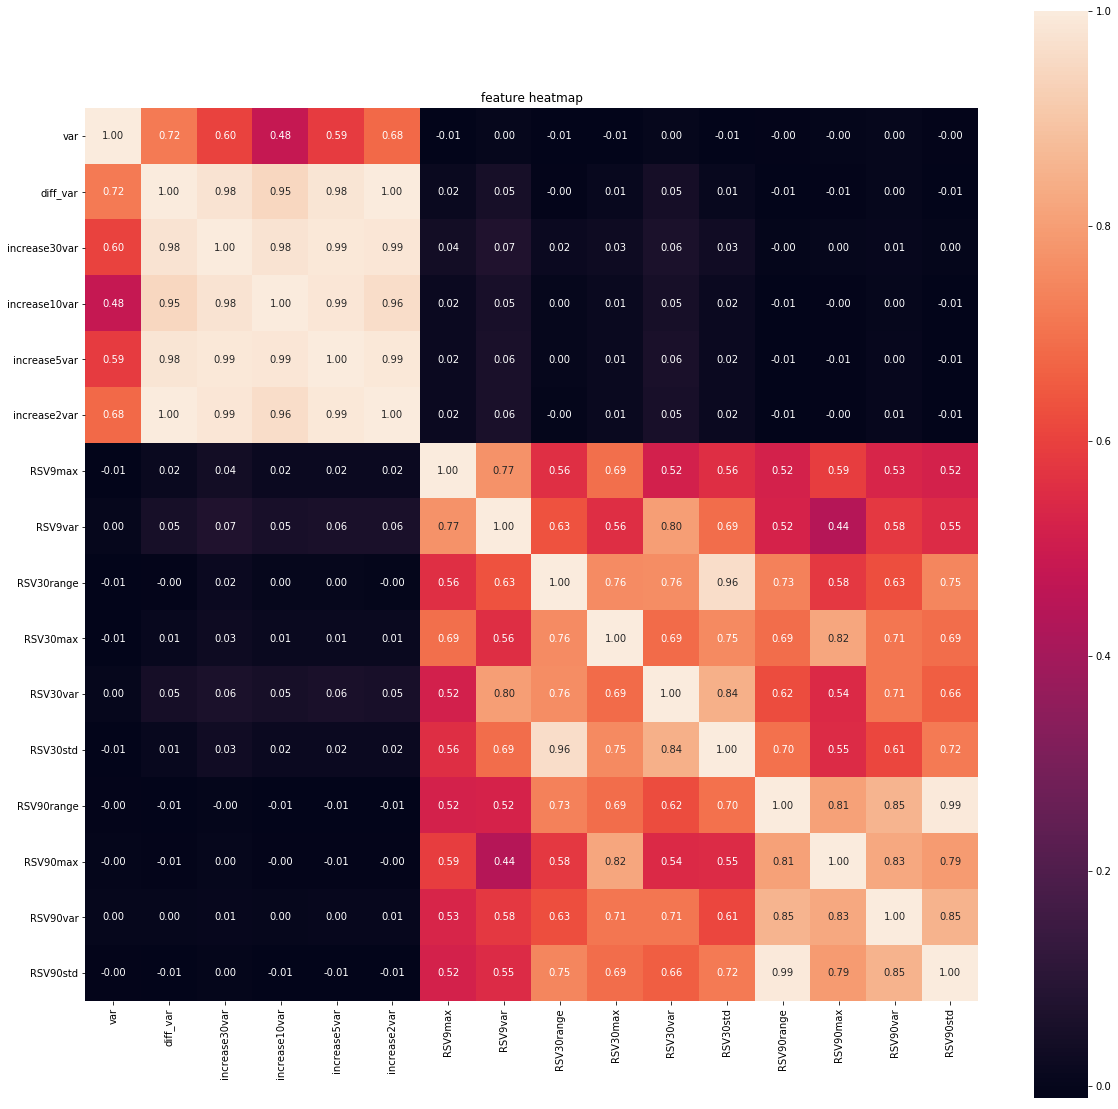

In [50]:
plot_heatmap(useful_feature, step=1)

In [51]:
def deal_related(data):
    data.drop('RSV90range', axis=1, inplace=True)
    data.drop('increase30var', axis=1, inplace=True)
    data.drop('increase10var', axis=1, inplace=True)
    data.drop('increase5var', axis=1, inplace=True)
    data.drop('increase2var', axis=1, inplace=True)
    data.drop('RSV30range', axis=1, inplace=True)
    important_features = data.columns
    return data, important_features

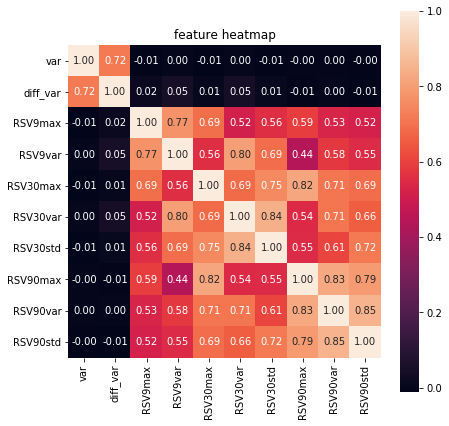

In [52]:
useful_feature, important_features = deal_related(useful_feature)
plot_heatmap(useful_feature, step=2)

In [53]:
useful_feature.head(10)

var  diff_var        RSV9max       RSV9var      RSV30max  \
0    5.398240  0.032365   33237.203443  7.479355e+05  22601.618341   
1   63.209115  0.161990   81422.808232  2.508395e+07      2.030599   
2    7.160926  0.046876       2.999949  4.190494e+06      1.816309   
3   12.840154  0.027746  112702.273630  1.543326e+07  88679.516693   
4    6.333109  0.070069   78406.282975  4.635426e+06  78406.282975   
5    4.977105  0.056453   75977.274768  3.200100e+06      2.397410   
6    6.674931  0.071005  146745.187513  1.357979e+07      2.071402   
7  503.327887  1.923396       4.999976  5.009675e+06      1.924039   
8    3.987816  0.033272       5.332722  4.516714e+04      1.914616   
9  318.388091  1.466206       3.718157  1.645392e+08      1.518517   

       RSV30var      RSV30std  RSV90max      RSV90var      RSV90std  
0  2.389199e+05    488.908710  1.647052  1.097657e-01      0.331389  
1  2.222180e+07   4715.104155  1.586400  2.286343e+07   4782.723807  
2  4.231653e+06   2057.579711  1.358405  4.353833e+06   2087.086645  
3  5.028792e+06   2243.021583  1.531046  1.245125e-01      0.352948  
4  4.680940e+06   2164.054441  1.623858  9.960706e-02      0.315682  
5  1.561843e-01      0.395294  1.425075  1.043371e-01      0.323090  
6  1.550394e-01      0.393843  1.476188  1.175297e-01      0.342909  
7  1.461550e-01      0.382392  1.317827  1.103193e-01      0.332223  
8  4.561043e+04    213.615965  1.458327  1.052088e-01      0.324437  
9  1.661553e+08  12893.141984  1.491056  1.709529e+08  13078.043023

### 观察Box-Cox变换之前的样本分布 

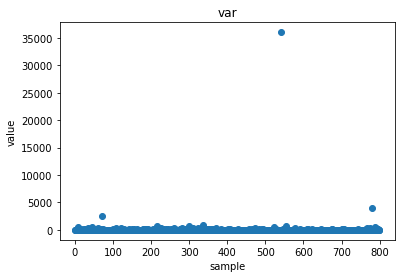

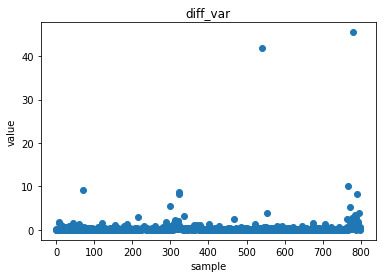

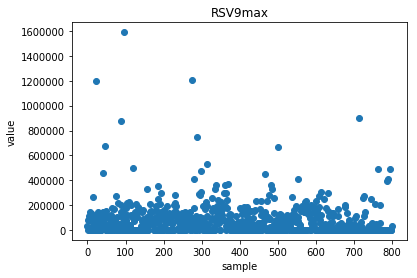

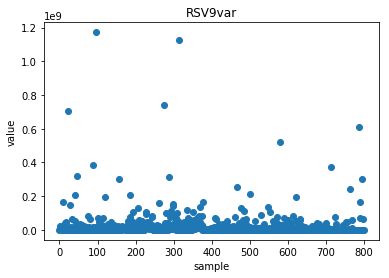

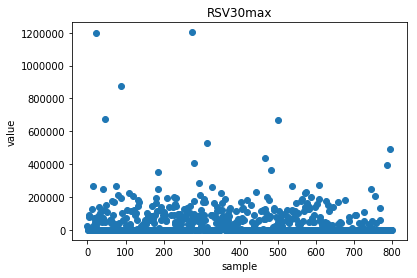

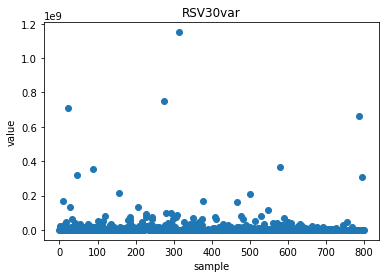

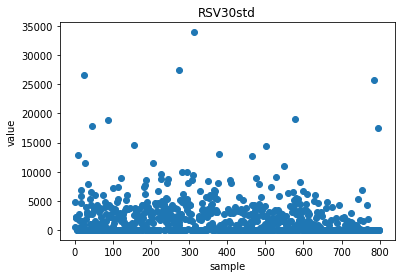

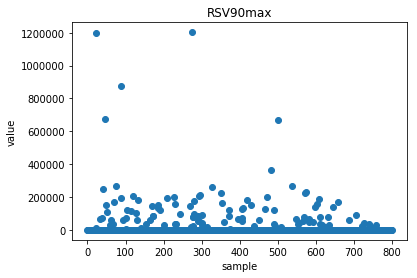

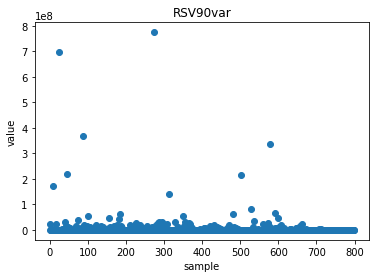

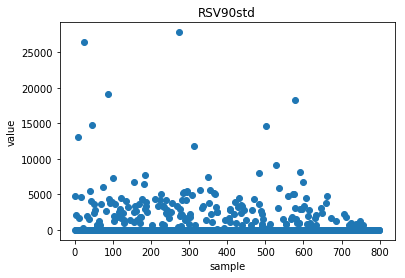

In [54]:
def scan_samp(data):
    for i in data.columns:
        x = list(np.arange(len(data[i])))
        y = list(deepcopy(data[i]))
        plt.figure()
        plt.scatter(x, y)
        plt.title(i)
        plt.xlabel('sample')
        plt.ylabel('value')
        plt.show()
scan_samp(useful_feature)

### 观察特征的正态跟随性 

In [55]:
def plot_distribute(data, important_features):
    mpl.rcParams['font.sans-serif'] = ['FangSong']
    mpl.rcParams['axes.unicode_minus'] = False
    plt.figure()
    #important_features = ['var']
    for i in important_features:
        sns.distplot(data[i], fit=norm)
        plt.xlabel('value')
        (mu,sigma) = norm.fit(data[i])
        print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
        plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
        plt.ylabel('Frequency')
        plt.title(i)
        plt.savefig('../img/var.jpg', dpi=600) 
        plt.figure()
        #stats.probplot(data[i], plot=plt)
        #plt.savefig('../img/varQQ.jpg', dpi=600) 
        plt.show()


 mu = 96.40 and sigma = 1284.73



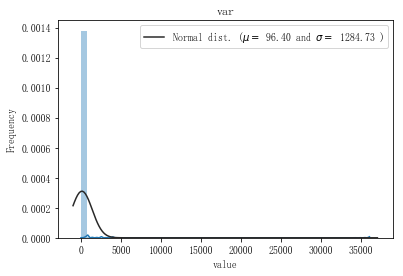


 mu = 0.43 and sigma = 2.33



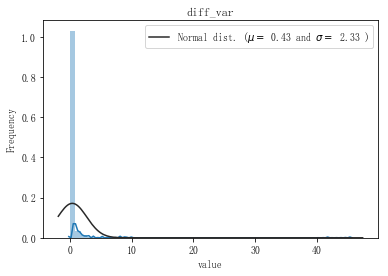


 mu = 78748.87 and sigma = 131056.44



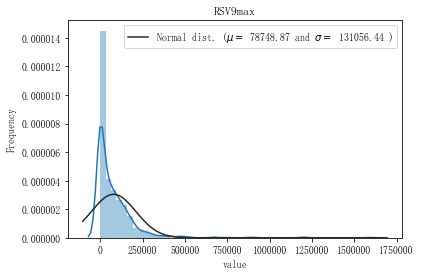


 mu = 24550989.87 and sigma = 83174560.96



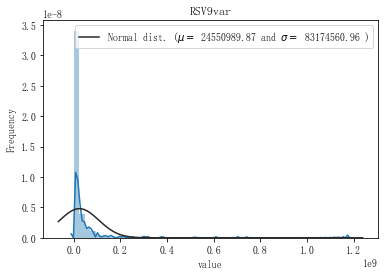


 mu = 44831.24 and sigma = 99936.15



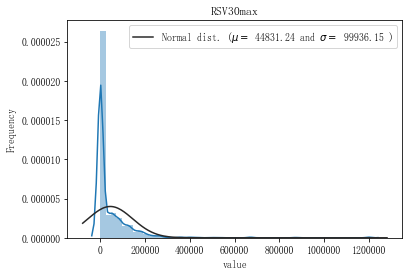


 mu = 14378596.79 and sigma = 66628358.63



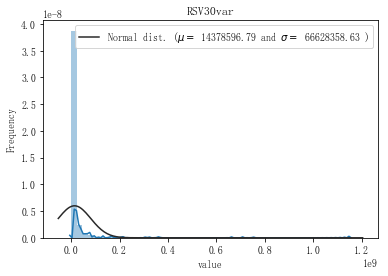


 mu = 1918.31 and sigma = 3272.67



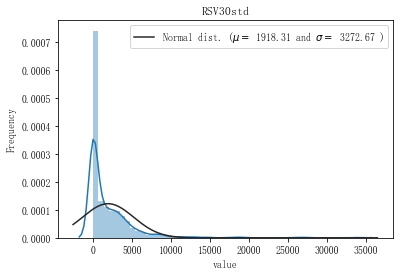


 mu = 19093.58 and sigma = 85794.59



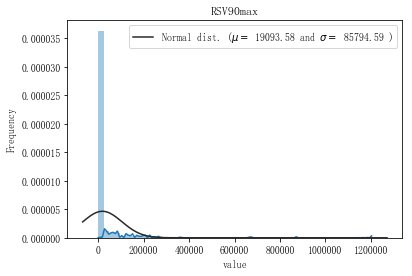


 mu = 6144139.55 and sigma = 43372044.83



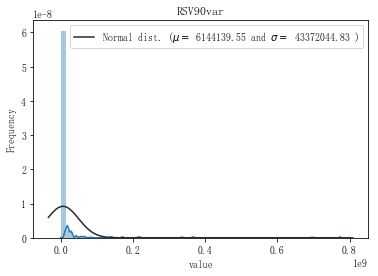


 mu = 812.61 and sigma = 2342.43



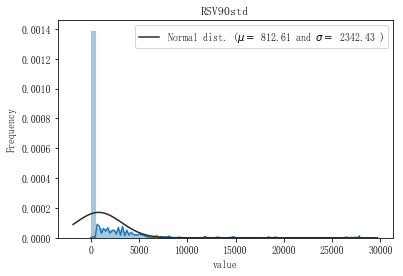

In [56]:
plot_distribute(useful_feature, important_features)

### 特征做Box-Cox变换 

In [57]:
def boxcox_reverse(data, important_features):
    plt.figure()
    # important_features = ['var']
    for i in important_features:
        soft ,b = stats.boxcox(data[i])
        mpl.rcParams['font.sans-serif'] = ['FangSong']
        mpl.rcParams['axes.unicode_minus'] = False
        sns.distplot(soft, fit=norm)
        plt.xlabel('value')
        (mu,sigma) = norm.fit(soft)
        print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
        plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
        plt.ylabel('Frequency')
        plt.title('var reverse')
        #plt.savefig('../img/varBC.jpg', dpi=600) 
        plt.figure()
        stats.probplot(soft, plot=plt)
        plt.savefig('../img/varBC_QQ.jpg', dpi=600) 
        plt.show()


 mu = 2.54 and sigma = 1.29



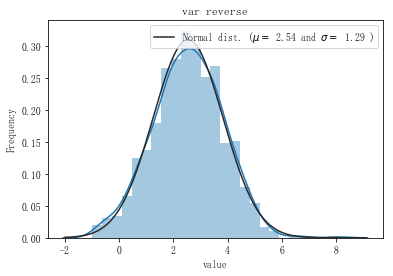

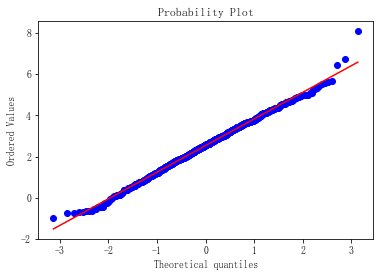


 mu = -2.43 and sigma = 1.61



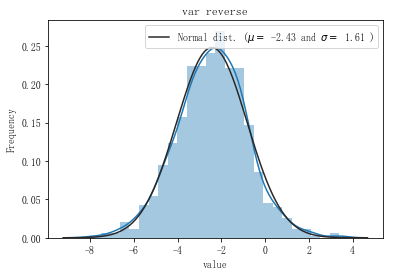

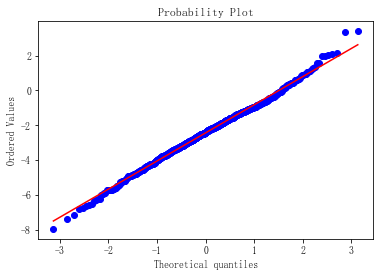


 mu = 13.49 and sigma = 9.88



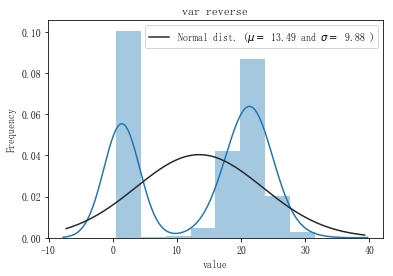

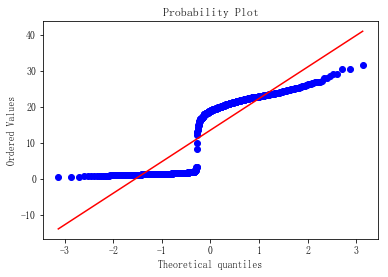


 mu = 35.20 and sigma = 23.71



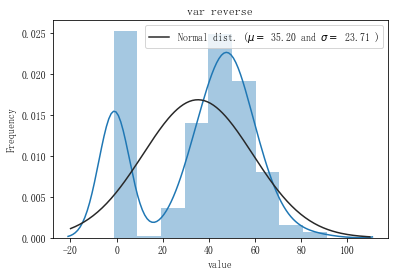

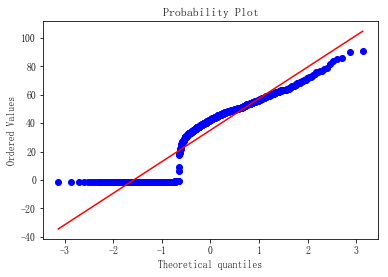


 mu = 2.84 and sigma = 2.68



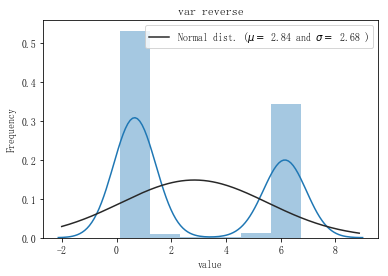

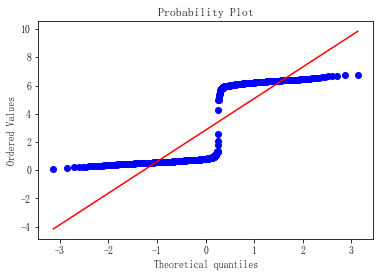


 mu = 8.41 and sigma = 9.67



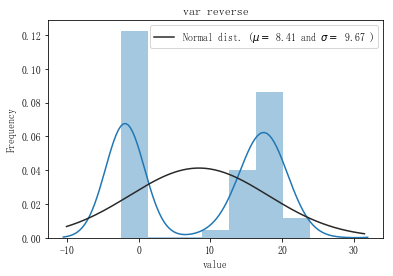

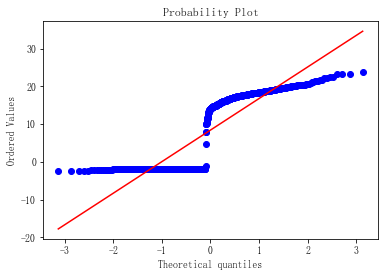


 mu = 4.20 and sigma = 4.84



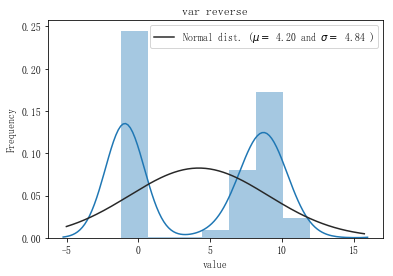

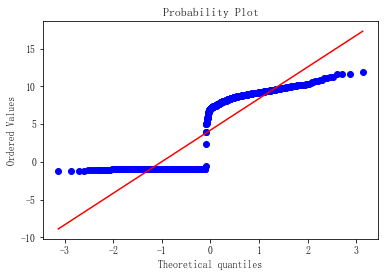


 mu = 0.56 and sigma = 0.54



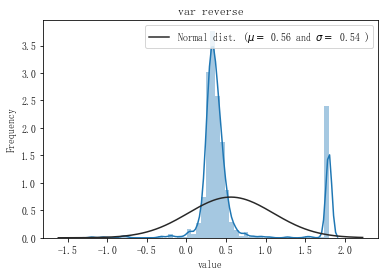

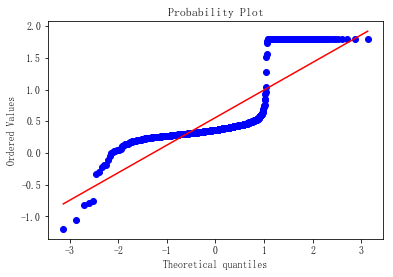


 mu = -1.05 and sigma = 3.30



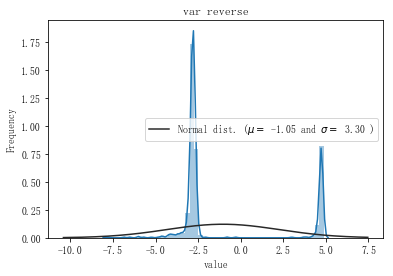

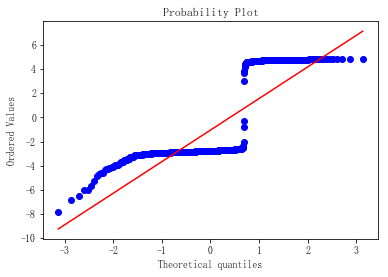


 mu = -0.52 and sigma = 1.65



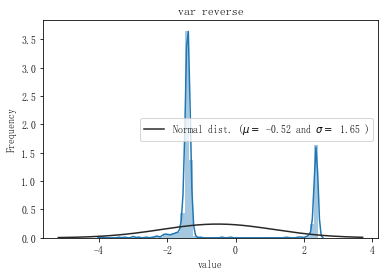

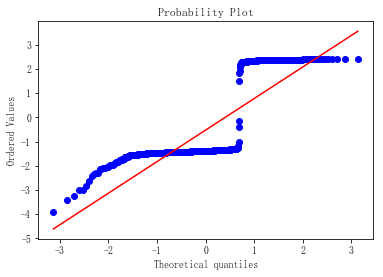

In [58]:
boxcox_reverse(useful_feature, important_features)

In [59]:
def boxcox_trans(data, feature_name):
    soft ,b = stats.boxcox(data[feature_name])
    data[feature_name] = soft
    print(b)
    return data

In [60]:
useful_feature = boxcox_trans(useful_feature, feature_name='RSV90std')
useful_feature = boxcox_trans(useful_feature, feature_name='var')
useful_feature = boxcox_trans(useful_feature, feature_name='diff_var')
useful_feature = boxcox_trans(useful_feature, feature_name='RSV9max')
useful_feature = boxcox_trans(useful_feature, feature_name='RSV9var')
useful_feature = boxcox_trans(useful_feature, feature_name='RSV30max')
useful_feature = boxcox_trans(useful_feature, feature_name='RSV30var')
useful_feature = boxcox_trans(useful_feature, feature_name='RSV30std')
useful_feature = boxcox_trans(useful_feature, feature_name='RSV90max')
useful_feature = boxcox_trans(useful_feature, feature_name='RSV90var')
useful_feature.head(10)

-0.40502201029595186
-0.05238087048457632
-0.06271303602011327
0.09916758089913133
0.11791569952495923
-0.1206812080905656
0.012603192814168529
0.02520430499950068
-0.5542377015518111
-0.20246775192027808


var  diff_var    RSV9max    RSV9var  RSV30max   RSV30var   RSV30std  \
0  1.613762 -3.827701  18.231860  33.307133  5.815153  13.402603   6.701531   
1  3.727060 -1.928178  20.862955  54.750841  0.678901  18.855209   9.427808   
2  1.870538 -3.373642   1.160672  42.722601  0.575821  16.823917   8.412173   
3  2.389288 -4.019555  21.876902  51.231193  6.190971  17.033326   8.516877   
4  1.759369 -2.892693  20.747315  43.335497  6.159604  16.946296   8.473362   
5  1.539245 -3.149694  20.651248  41.120233  0.829836  -1.835163  -0.917354   
6  1.807027 -2.877032  22.724525  50.337120  0.697144  -1.842350  -0.920947   
7  5.309265  0.640858   1.744983  43.812069  0.629251  -1.899970  -0.949757   
8  1.334321 -3.793422   1.820803  21.532063  0.624713  11.486948   5.743709   
9  4.974660  0.378123   1.402575  70.451802  0.407379  21.376981  10.688678   

   RSV90max  RSV90var  RSV90std  
0  0.435932 -2.786302 -1.392846  
1  0.407180  4.779229  2.389171  
2  0.281721  4.715450  2.357306  
3  0.379406 -2.591625 -1.295508  
4  0.425134 -2.939706 -1.469548  
5  0.321621 -2.866044 -1.432717  
6  0.350297 -2.680139 -1.339765  
7  0.255913 -2.778437 -1.388913  
8  0.340454 -2.852908 -1.426149  
9  0.358351  4.832705  2.415885

### 观察样本分布 

In [61]:
def scan_outside_samp(data):
    for i in data.columns:
        x = list(np.arange(len(data[i])))
        y = list(deepcopy(data[i]))
        plt.figure()
        plt.scatter(x, y)
        plt.title(i)
        plt.xlabel('sample')
        plt.ylabel('value')
        plt.show()

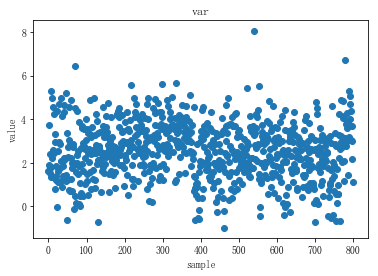

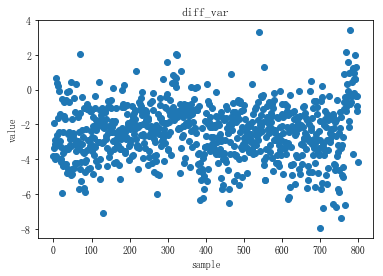

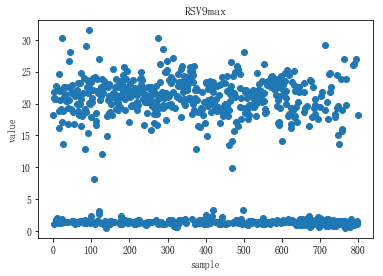

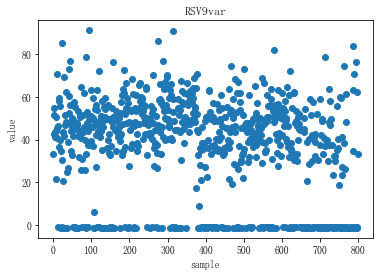

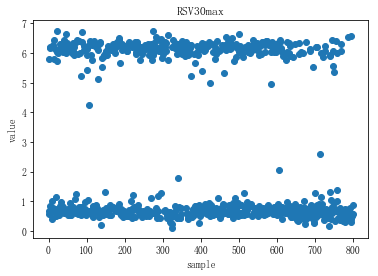

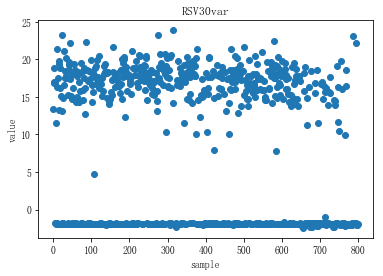

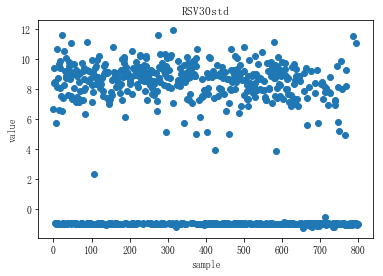

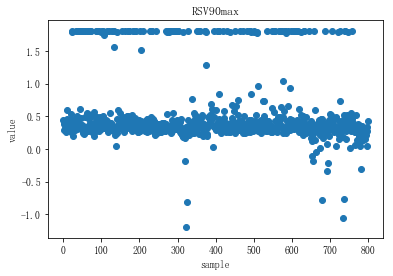

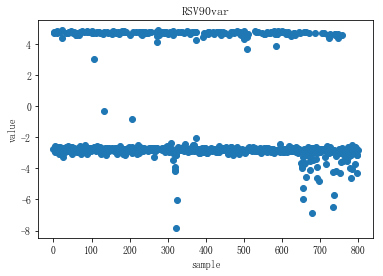

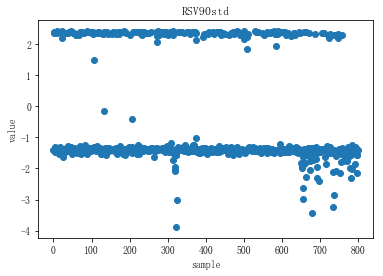

In [62]:
scan_outside_samp(useful_feature)

### 绘制箱形图观察离群值 

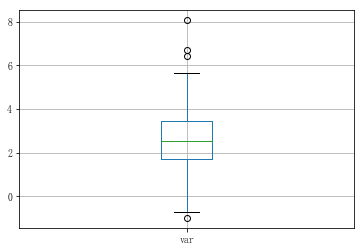

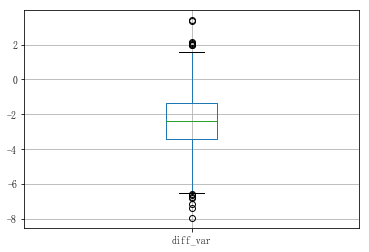

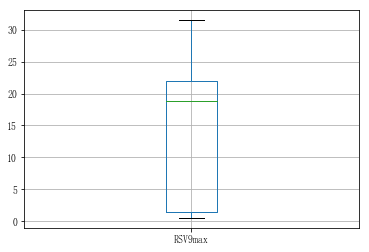

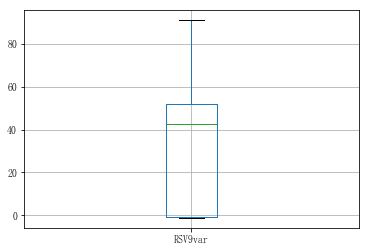

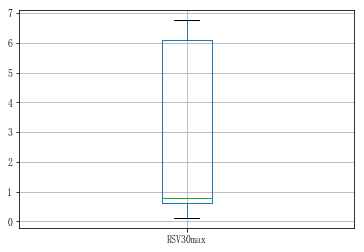

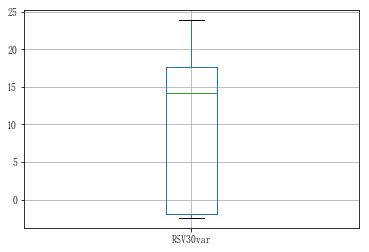

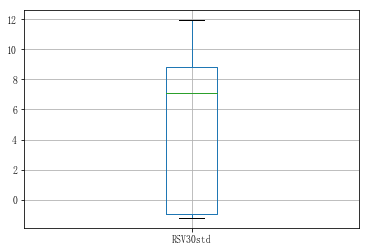

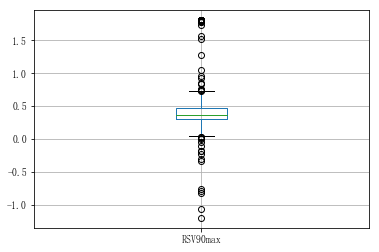

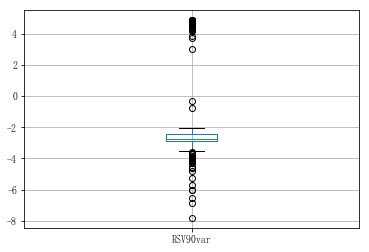

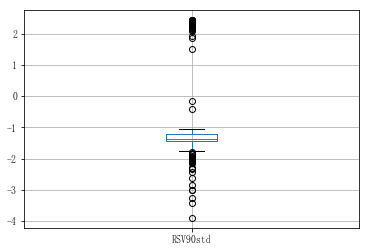

In [63]:
for i in useful_feature.columns:
    box = useful_feature.boxplot(column=[i])
    plt.show()

### 绘制特征之间的散点图 

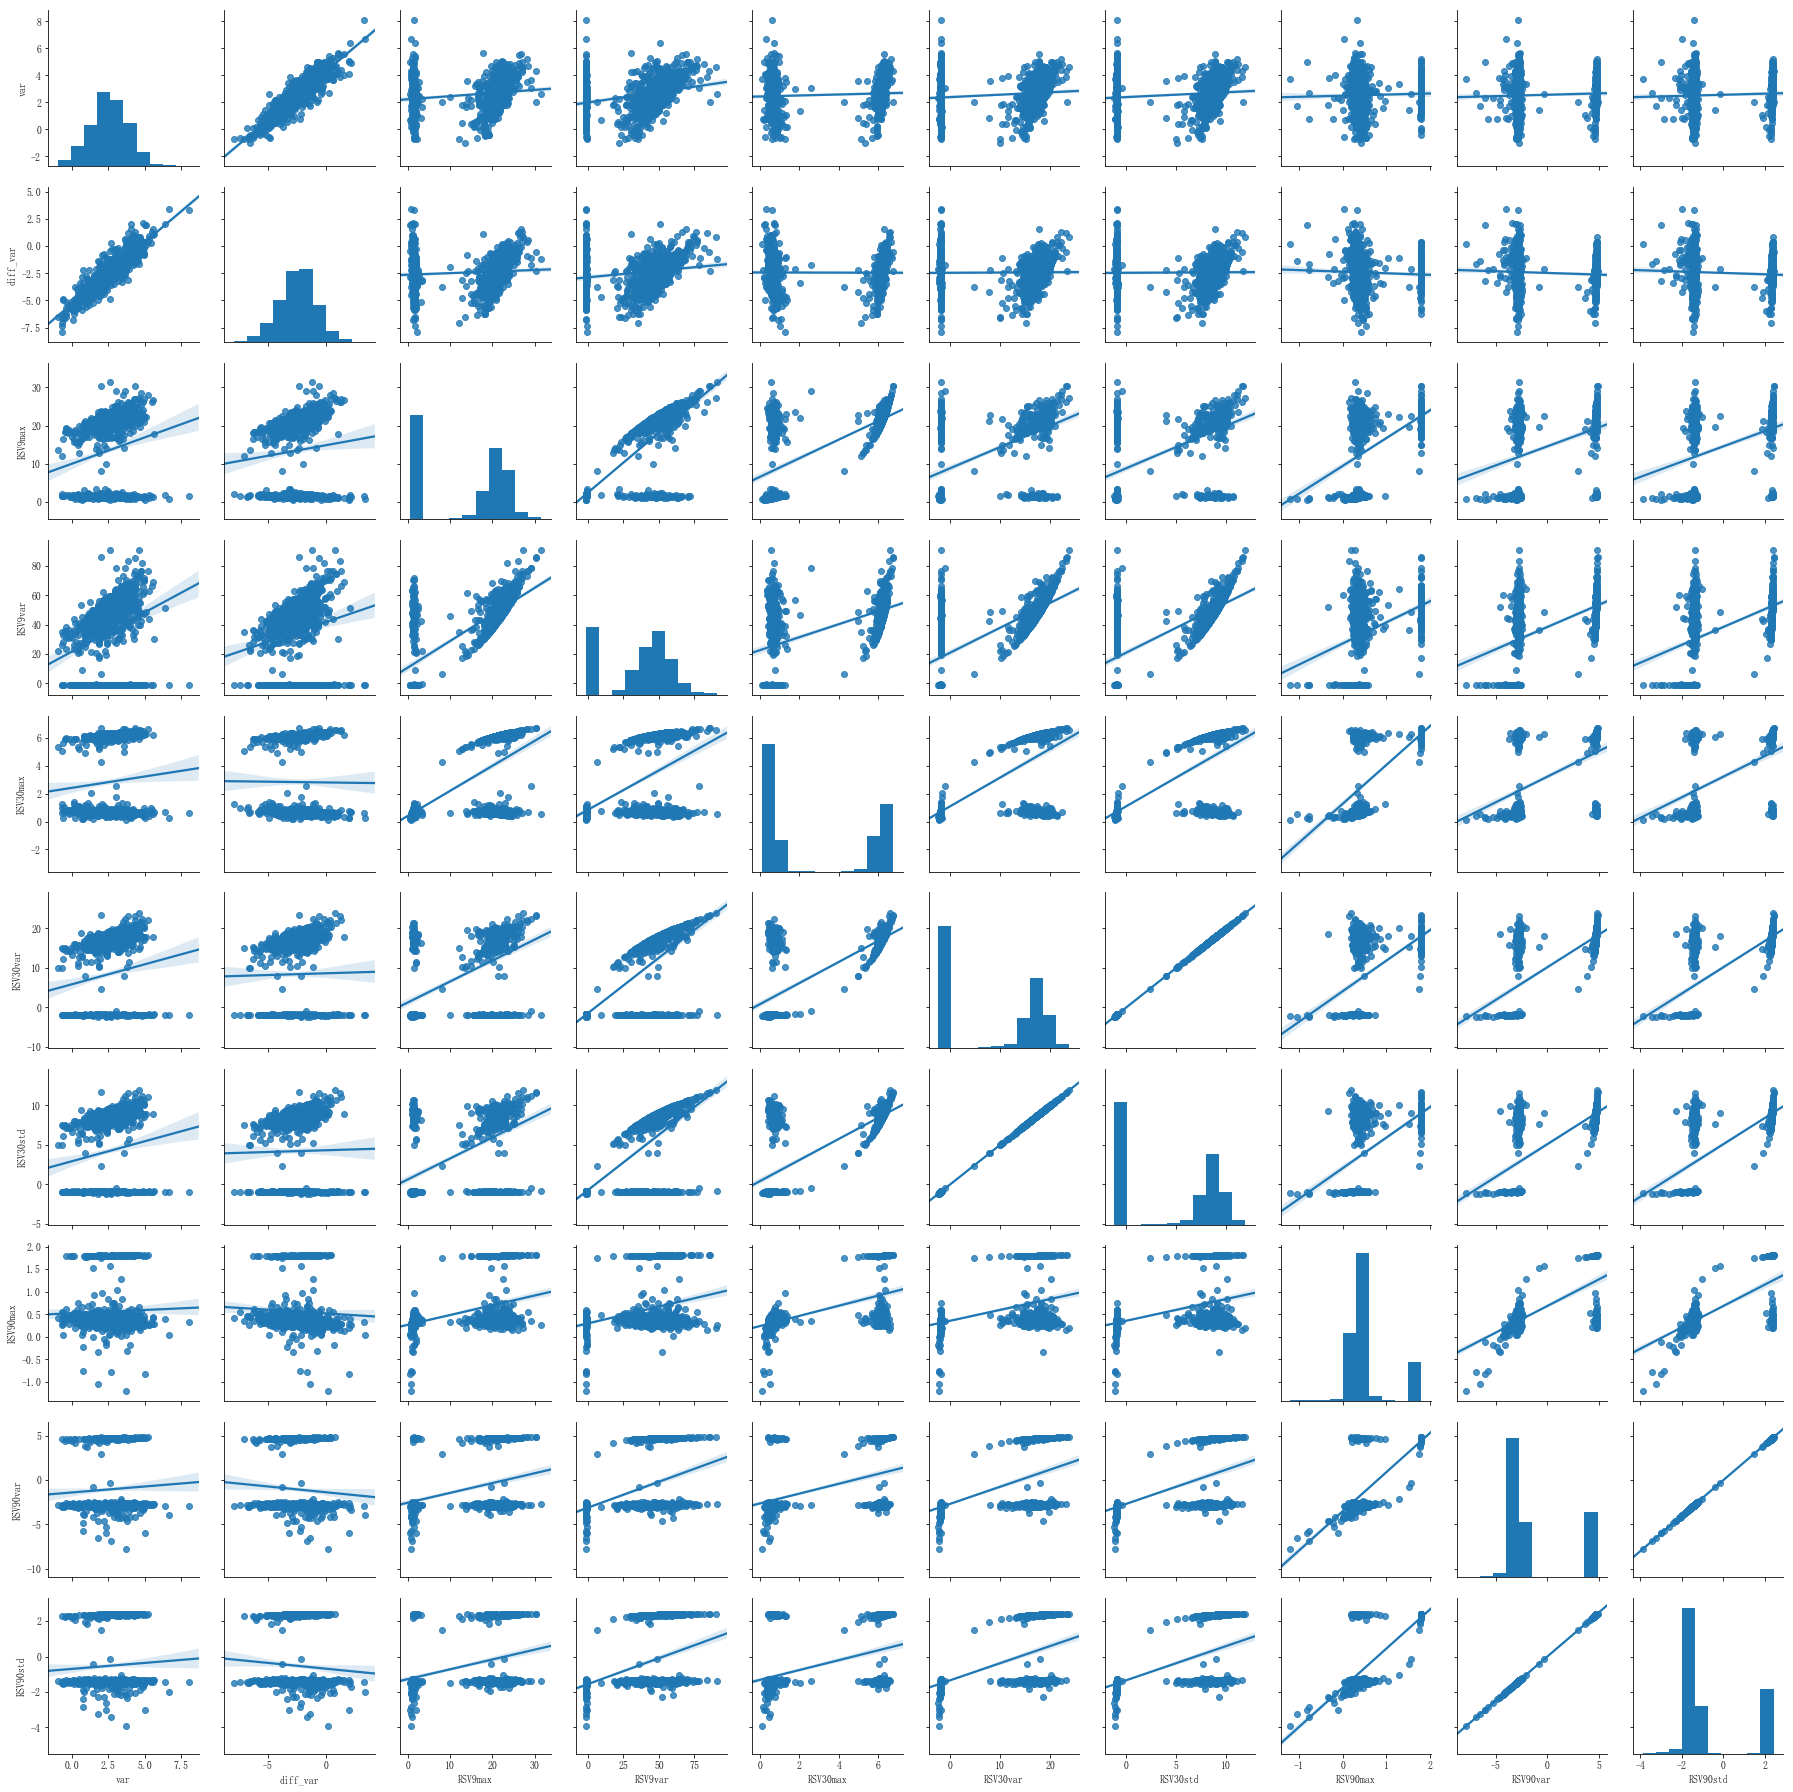

In [64]:
seaborn.pairplot(useful_feature, vars=useful_feature.columns, kind='reg')
plt.show()

### 样本特征加权 

In [65]:
def add_weight(useful_feature, entropy_weight):
    weight = {}
    feature = useful_feature.columns
    for i in feature:
        weight[i] = entropy_weight[i]
    Key = []
    Value = []
    for key, value in weight.items():
        Key.append(key)
        Value.append(value)
    Sum = sum(Value)
    Value2 = []
    for i in Value:
        Value2.append(i / Sum)
    weight = {}
    for i in range(len(Value)):
        weight[Key[i]] = Value2[i]
    for i in feature:
        useful_feature[i] = useful_feature[i] * weight[i]
    return useful_feature

In [66]:
useful_feature = add_weight(useful_feature, entropy_weight)

## 建立聚类模型 

In [67]:
def plot(data_norm, result, title):
    tsne = TSNE()
    tsne.fit_transform(data_norm)                   # 流行学习降维
    tsne = pd.DataFrame(tsne.embedding_, index=data_norm.index)
    plt.rcParams['font.sans-serif'] = ['SimHei']    # 中文正确显示
    plt.rcParams['axes.unicode_minus'] = False      # 负号正确显示
    d1 = tsne[result['label'] == 1]          # 绘图
    plt.plot(d1[0], d1[1], 'r.', label=u'cluster1', alpha=0.7, markersize=5)
    d2 = tsne[result['label'] == 2]           
    plt.plot(d2[0], d2[1], 'co', label=u'cluster2', alpha=0.7, markersize=5)
    d3 = tsne[result['label'] == 3]           
    plt.plot(d3[0], d3[1], '*', color='0.6', label=u'cluster3', alpha=0.7, markersize=5)
    #d4 = tsne[result['label'] == 4]           
    #plt.plot(d4[0], d4[1], 'm+', label=u'cluster4', alpha=0.7, markersize=5)
    plt.legend([u'cluster1', u'cluster2', u'cluster3'],
               loc='upper right')
    # plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(ls='--')
    # 保存高清图片
    name = "../img/" + title + ".jpg"
    plt.savefig(name, dpi=600) 
    plt.show()

In [68]:
def plate_show(data):
    font2 = {'family': 'Times New Roman','weight' :'normal','size': 20,}
    plt.figure()
    plt.grid(ls='--')
    mean = list(deepcopy(data['mean']))
    std = list(deepcopy(data['std']))
    plt.scatter(mean, std, marker='o', s=100, label='cluster point')
    #plt.title('mean&std', font2)
    plt.xlabel('mean', font2)
    plt.ylabel('std', font2)
    plt.legend()
    name = "../img/"+"1.jpg"
    plt.savefig(name, dpi=600) 
    plt.show()
    mean_s = pd.Series(mean)    # 计算相关系数
    std_s = pd.Series(std)
    print(mean_s.corr(std_s))

### K-means聚类

In [69]:
def KMeans_cluser(useful_feature, data_id, data_score, important_features, n):
    model = KMeans(n_clusters=n, n_jobs=11, max_iter=10)
    model.fit(useful_feature)
    score_sil = metrics.silhouette_score(useful_feature, model.labels_, metric='euclidean')
    print("当聚为%d簇时，KMeans轮廓系数Silhouette Coefficient为：%f" % (n, score_sil))             # 计算轮廓系数
    score_cal = metrics.calinski_harabaz_score(useful_feature, model.labels_) 
    print("当聚为%d簇时，KMeans轮廓系数Calinski-Harabaz Index为：%f" % (n, score_cal))
    score_dbi = metrics.davies_bouldin_score(useful_feature, model.labels_)                       # DBI值越小越好（说明分散程度低）
    print("当聚为%d簇时，KMeans Davies-Bouldin分数值为：%f" % (n, score_dbi))
    label_counts = pd.Series(model.labels_).value_counts()
    centers = pd.DataFrame(model.cluster_centers_)
    report = pd.concat([centers, label_counts], axis=1)
    report.columns = list(useful_feature.columns) + ['label_counts']
    kmeans_result = pd.concat([useful_feature, pd.Series(model.labels_, index=useful_feature.index)], axis=1)
    kmeans_result.columns = list(useful_feature.columns) + ['label']
    kmeans_result.insert(0, 'eventid', data_id)
    kmeans_result['overall'] = data_score
    center_overall_sum = {}
    for i in range(n):
        temp = (kmeans_result[kmeans_result.label == i])['overall'].sum()
        key_word = '第' + str(i) + '类'
        center_overall_sum[key_word] = temp
    center_overall_sum = sorted(center_overall_sum.items(), key = lambda x:x[1], reverse = True)
    Old_label = []
    New_label = []
    num = 0
    for i in center_overall_sum:
        num += 1
        Old_label.append(int(i[0][1]))
        New_label.append(num)
    label = list(deepcopy(kmeans_result['label']))
    temp = []
    for i in range(len(label)):
        for j in range(n):
            if label[i] == Old_label[j]:
                temp.append(New_label[j])
    kmeans_result.drop('label', axis=1, inplace=True)
    kmeans_result['label'] = temp
    return kmeans_result, report

### 大板块K-means聚类结果 

In [70]:
start = time.clock()
kmeans_result, report = KMeans_cluser(useful_feature, data_id, data_score, important_features, n)
end = time.clock()
print('KMeans running time', end-start)

当聚为3簇时，KMeans轮廓系数Silhouette Coefficient为：0.553890
当聚为3簇时，KMeans轮廓系数Calinski-Harabaz Index为：1730.488254
当聚为3簇时，KMeans Davies-Bouldin分数值为：0.758144
KMeans running time 0.09023763762127902


In [71]:
print(report)

        var  diff_var   RSV9max   RSV9var  RSV30max  RSV30var  RSV30std  \
0  0.250829 -0.239588  0.895327  4.090932  0.071777 -0.147647 -0.041620   
1  0.273483 -0.234346  1.044761  4.780496  0.382681  1.950278  0.550013   
2  0.239379 -0.227971  0.090433 -0.038836  0.056013 -0.185932 -0.052402   

   RSV90max  RSV90var  RSV90std  label_counts  
0  0.048441 -0.411690 -0.156176           166  
1  0.107744  0.096817  0.036739           421  
2  0.041161 -0.437444 -0.165885           213  


In [72]:
kmeans_result.head(10)

eventid       var  diff_var   RSV9max   RSV9var  RSV30max  RSV30var  \
0  000001.SZ  0.165104 -0.367831  1.026503  3.173860  0.472816  1.508373   
1  000002.SZ  0.381317 -0.185292  1.174640  5.217246  0.055200  2.122027   
2  000006.SZ  0.191375 -0.324197  0.065349  4.071067  0.046819  1.893419   
3  000008.SZ  0.244449 -0.386268  1.231728  4.881856  0.503372  1.916986   
4  000009.SZ  0.180002 -0.277979  1.168130  4.129470  0.500822  1.907192   
5  000012.SZ  0.157481 -0.302676  1.162721  3.918376  0.067472 -0.206535   
6  000021.SZ  0.184877 -0.276474  1.279452  4.796660  0.056683 -0.207344   
7  000025.SZ  0.543192  0.061585  0.098247  4.174883  0.051163 -0.213829   
8  000027.SZ  0.136515 -0.364537  0.102516  2.051805  0.050794  1.292779   
9  000028.SZ  0.508959  0.036337  0.078969  6.713402  0.033123  2.405836   

   RSV30std  RSV90max  RSV90var  RSV90std   overall  label  
0  0.425390  0.060584 -0.401877 -0.152464  0.000287      1  
1  0.598445  0.056588  0.689324  0.261523  0.002134      1  
2  0.533976  0.039153  0.680125  0.258035  0.000859      1  
3  0.540622  0.052729 -0.373798 -0.141809  0.000604      1  
4  0.537860  0.059084 -0.424003 -0.160859  0.000530      1  
5 -0.058230  0.044698 -0.413379 -0.156828  0.000275      3  
6 -0.058459  0.048683 -0.386565 -0.146653  0.000360      3  
7 -0.060287  0.035566 -0.400743 -0.152033  0.001832      3  
8  0.364591  0.047315 -0.411484 -0.156109  0.000224      2  
9  0.678481  0.049802  0.697036  0.264447  0.008570      1

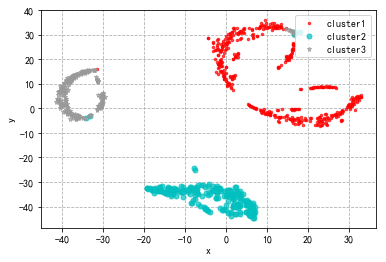

In [73]:
# 流行学习聚类结果可视化
plot(useful_feature, kmeans_result, title='基于K-means的股票聚类结果可视化分析')

### 绘制词云 

In [74]:
def wordcloud_object(word_string):
    stopwords = set('')
    stopwords.update(['中国', '股份', '集团', '控股', '科技', '上海', '东方'])
    FONT_ROOT = './fonts/'
    wordcloud = WordCloud(font_path=FONT_ROOT+'simhei.ttf', stopwords=stopwords, background_color='white', width=800, height=600).generate(' '.join(word_string))
    return wordcloud
def plot_wordcloud(df, clusters, pivot, ID_name):
    data = deepcopy(df)
    data['shares_name'] = list(deepcopy(ID_name['shares_name']))
    fig = plt.figure(figsize=(15, 30))
    for cluster in range(clusters):
        List_ = []
        for x in data[data['label']==cluster+1][pivot]:
            try:
                List_.extend(jieba.cut_for_search(x))
            except:
                pass
        if List_:
            ax = fig.add_subplot(5, 2, cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster: %d' % (cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')
    fig.set_tight_layout(True)
    plt.show()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wzy\AppData\Local\Temp\jieba.cache
Loading model cost 0.929 seconds.
Prefix dict has been built succesfully.


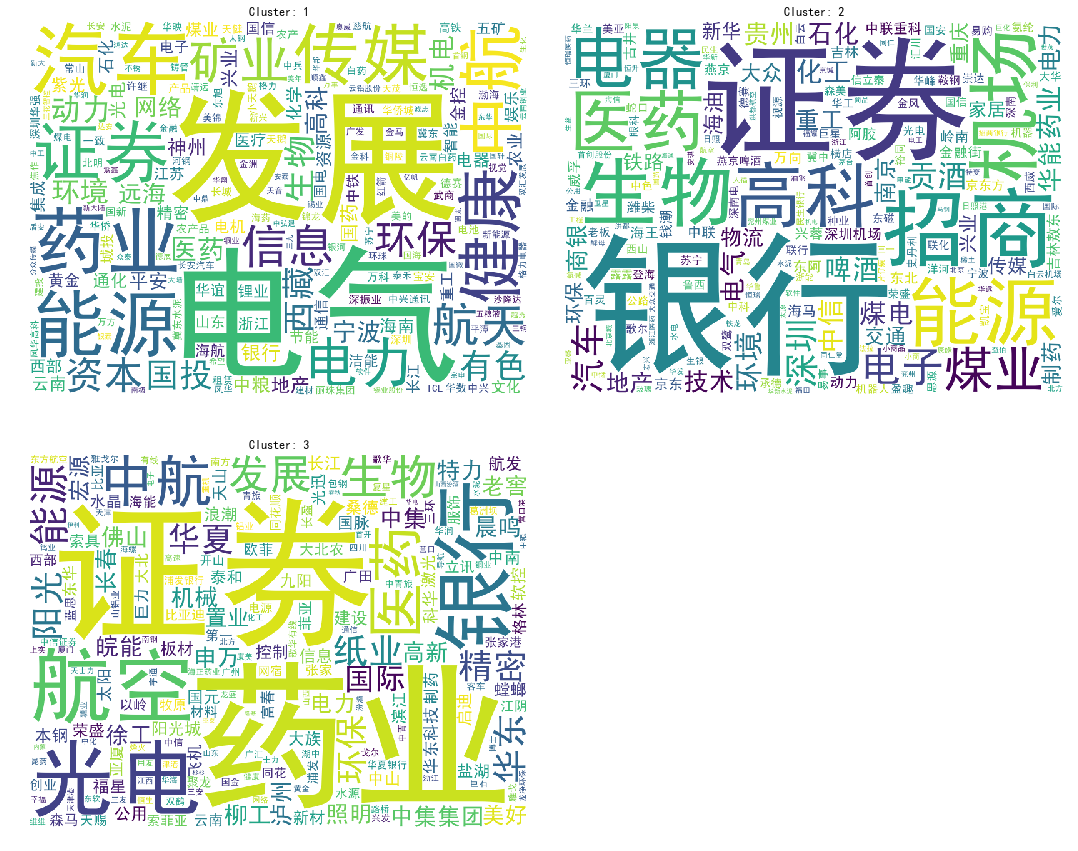

In [75]:
plot_wordcloud(kmeans_result, n, 'shares_name', ID_name)

### 高斯混合模型 

In [76]:
def Gaussian_Mixture_cluser(useful_feature, data_id, data_score, important_features, n, cv_type):
    model = mixture.GaussianMixture(n_components=n, covariance_type=cv_type, random_state=4, max_iter=10000)
    model.fit(useful_feature)
    labels = model.predict(useful_feature)
    score_sil = metrics.silhouette_score(useful_feature, labels, metric='euclidean')
    print("当聚为%d簇时，高斯混合模型轮廓系数Silhouette Coefficient为：%f" % (n, score_sil))             # 计算轮廓系数
    score_cal = metrics.calinski_harabaz_score(useful_feature, labels) 
    print("当聚为%d簇时，高斯混合模型轮廓系数Calinski-Harabaz Index为：%f" % (n, score_cal))
    score_dbi = metrics.davies_bouldin_score(useful_feature, labels)                                     # DBI值越小越好（说明分散程度低）
    print("当聚为%d簇时，高斯混合模型 Davies-Bouldin分数值为：%f" % (n, score_dbi))
    Gaussian_result = pd.concat([useful_feature, pd.Series(labels, index=useful_feature.index)], axis=1)
    Gaussian_result.columns = list(useful_feature.columns) + ['label']
    Gaussian_result.insert(0, 'eventid', data_id)
    Gaussian_result['overall'] = data_score
    center_overall_sum = {}
    for i in range(n):
        temp = (Gaussian_result[Gaussian_result.label == i])['overall'].sum()
        key_word = '第' + str(i) + '类'
        center_overall_sum[key_word] = temp
    center_overall_sum = sorted(center_overall_sum.items(), key = lambda x:x[1], reverse = True)
    Old_label = []
    New_label = []
    num = 0
    for i in center_overall_sum:
        num += 1
        Old_label.append(int(i[0][1]))
        New_label.append(num)
    label = list(deepcopy(Gaussian_result['label']))
    temp = []
    for i in range(len(label)):
        for j in range(n):
            if label[i] == Old_label[j]:
                temp.append(New_label[j])
    Gaussian_result.drop('label', axis=1, inplace=True)
    Gaussian_result['label'] = temp
    return Gaussian_result

### 大板块高斯混合模型聚类结果 

In [77]:
start = time.clock()
Gaussian_result = Gaussian_Mixture_cluser(useful_feature, data_id, data_score, important_features, n, 'spherical')
end = time.clock()
print('Gaussian running time', end-start)

当聚为3簇时，高斯混合模型轮廓系数Silhouette Coefficient为：0.505493
当聚为3簇时，高斯混合模型轮廓系数Calinski-Harabaz Index为：1644.615635
当聚为3簇时，高斯混合模型 Davies-Bouldin分数值为：0.917108
Gaussian running time 0.05786972069359031


In [78]:
Gaussian_result.head(10)

eventid       var  diff_var   RSV9max   RSV9var  RSV30max  RSV30var  \
0  000001.SZ  0.165104 -0.367831  1.026503  3.173860  0.472816  1.508373   
1  000002.SZ  0.381317 -0.185292  1.174640  5.217246  0.055200  2.122027   
2  000006.SZ  0.191375 -0.324197  0.065349  4.071067  0.046819  1.893419   
3  000008.SZ  0.244449 -0.386268  1.231728  4.881856  0.503372  1.916986   
4  000009.SZ  0.180002 -0.277979  1.168130  4.129470  0.500822  1.907192   
5  000012.SZ  0.157481 -0.302676  1.162721  3.918376  0.067472 -0.206535   
6  000021.SZ  0.184877 -0.276474  1.279452  4.796660  0.056683 -0.207344   
7  000025.SZ  0.543192  0.061585  0.098247  4.174883  0.051163 -0.213829   
8  000027.SZ  0.136515 -0.364537  0.102516  2.051805  0.050794  1.292779   
9  000028.SZ  0.508959  0.036337  0.078969  6.713402  0.033123  2.405836   

   RSV30std  RSV90max  RSV90var  RSV90std   overall  label  
0  0.425390  0.060584 -0.401877 -0.152464  0.000287      3  
1  0.598445  0.056588  0.689324  0.261523  0.002134      1  
2  0.533976  0.039153  0.680125  0.258035  0.000859      1  
3  0.540622  0.052729 -0.373798 -0.141809  0.000604      1  
4  0.537860  0.059084 -0.424003 -0.160859  0.000530      1  
5 -0.058230  0.044698 -0.413379 -0.156828  0.000275      3  
6 -0.058459  0.048683 -0.386565 -0.146653  0.000360      3  
7 -0.060287  0.035566 -0.400743 -0.152033  0.001832      3  
8  0.364591  0.047315 -0.411484 -0.156109  0.000224      3  
9  0.678481  0.049802  0.697036  0.264447  0.008570      1

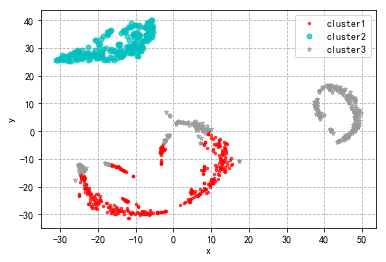

In [79]:
# 流行学习聚类结果可视化
plot(useful_feature, Gaussian_result, title='基于高斯混合模型的股票聚类结果可视化分析')

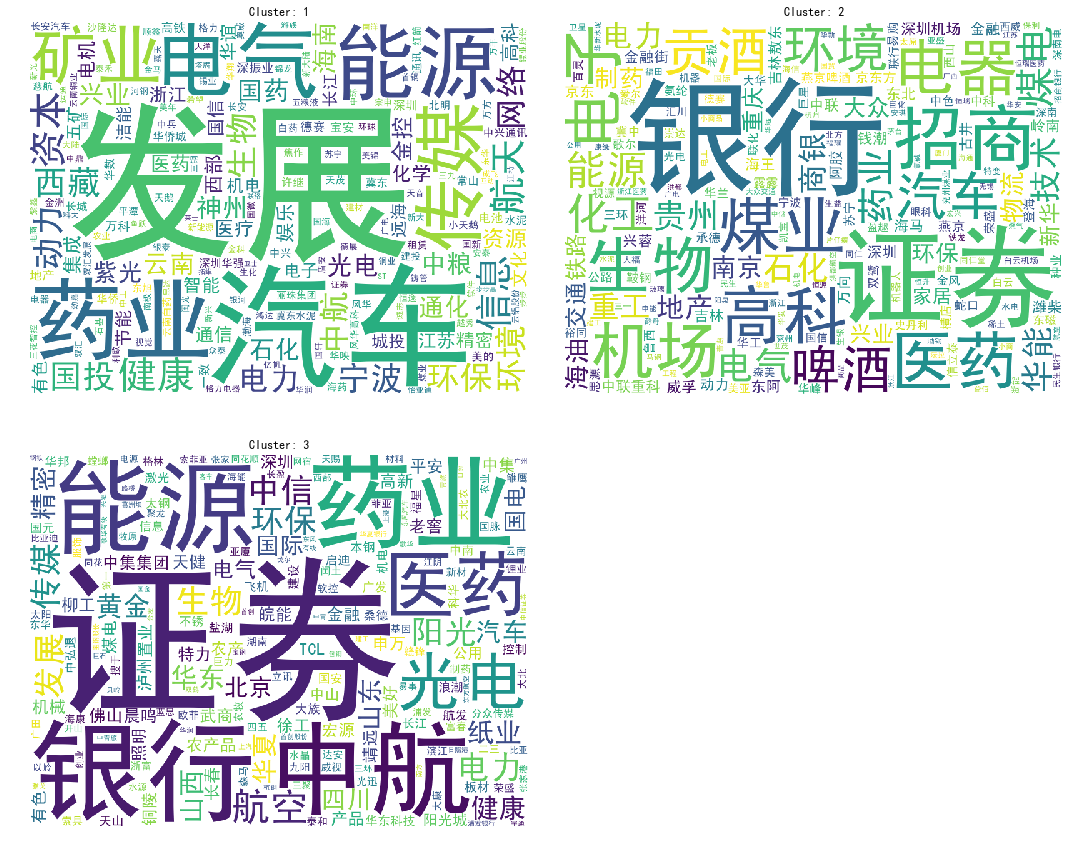

In [80]:
plot_wordcloud(Gaussian_result, n, 'shares_name', ID_name)

### 贝叶斯高斯混合模型聚类

In [81]:
def Bayesian_Gaussian_Mixture_cluser(useful_feature, data_id, data_score, important_features, n, cv_type):
    model = mixture.BayesianGaussianMixture(n_components=n, covariance_type=cv_type, random_state=0, max_iter=10000)
    model.fit(useful_feature)
    labels = model.predict(useful_feature)
    score_sil = metrics.silhouette_score(useful_feature, labels, metric='euclidean')
    print("当聚为%d簇时，贝叶斯高斯混合模型轮廓系数Silhouette Coefficient为：%f" % (n, score_sil))             # 计算轮廓系数
    score_cal = metrics.calinski_harabaz_score(useful_feature, labels) 
    print("当聚为%d簇时，贝叶斯高斯混合模型轮廓系数Calinski-Harabaz Index为：%f" % (n, score_cal))
    score_dbi = metrics.davies_bouldin_score(useful_feature, labels)                                     # DBI值越小越好（说明分散程度低）
    print("当聚为%d簇时，贝叶斯高斯混合模型 Davies-Bouldin分数值为：%f" % (n, score_dbi))
    Bayesian_Gaussian_result = pd.concat([useful_feature, pd.Series(labels, index=useful_feature.index)], axis=1)
    Bayesian_Gaussian_result.columns = list(useful_feature.columns) + ['label']
    Bayesian_Gaussian_result.insert(0, 'eventid', data_id)
    Bayesian_Gaussian_result['overall'] = data_score
    center_overall_sum = {}
    for i in range(n):
        temp = (Bayesian_Gaussian_result[Bayesian_Gaussian_result.label == i])['overall'].sum()
        key_word = '第' + str(i) + '类'
        center_overall_sum[key_word] = temp
    center_overall_sum = sorted(center_overall_sum.items(), key = lambda x:x[1], reverse = True)
    Old_label = []
    New_label = []
    num = 0
    for i in center_overall_sum:
        num += 1
        Old_label.append(int(i[0][1]))
        New_label.append(num)
    label = list(deepcopy(Bayesian_Gaussian_result['label']))
    temp = []
    for i in range(len(label)):
        for j in range(n):
            if label[i] == Old_label[j]:
                temp.append(New_label[j])
    Bayesian_Gaussian_result.drop('label', axis=1, inplace=True)
    Bayesian_Gaussian_result['label'] = temp
    return Bayesian_Gaussian_result

### 大板块贝叶斯高斯混合模型聚类结果 

In [82]:
start = time.clock()
Bayesian_Gaussian_result = Bayesian_Gaussian_Mixture_cluser(useful_feature, data_id, data_score, important_features, n, 'spherical')
end = time.clock()
print('Bayesian Gaussian running time', end-start)

当聚为3簇时，贝叶斯高斯混合模型轮廓系数Silhouette Coefficient为：0.504093
当聚为3簇时，贝叶斯高斯混合模型轮廓系数Calinski-Harabaz Index为：1658.365998
当聚为3簇时，贝叶斯高斯混合模型 Davies-Bouldin分数值为：0.922073
Bayesian Gaussian running time 0.11762195798305086


In [83]:
Bayesian_Gaussian_result.head(10)

eventid       var  diff_var   RSV9max   RSV9var  RSV30max  RSV30var  \
0  000001.SZ  0.165104 -0.367831  1.026503  3.173860  0.472816  1.508373   
1  000002.SZ  0.381317 -0.185292  1.174640  5.217246  0.055200  2.122027   
2  000006.SZ  0.191375 -0.324197  0.065349  4.071067  0.046819  1.893419   
3  000008.SZ  0.244449 -0.386268  1.231728  4.881856  0.503372  1.916986   
4  000009.SZ  0.180002 -0.277979  1.168130  4.129470  0.500822  1.907192   
5  000012.SZ  0.157481 -0.302676  1.162721  3.918376  0.067472 -0.206535   
6  000021.SZ  0.184877 -0.276474  1.279452  4.796660  0.056683 -0.207344   
7  000025.SZ  0.543192  0.061585  0.098247  4.174883  0.051163 -0.213829   
8  000027.SZ  0.136515 -0.364537  0.102516  2.051805  0.050794  1.292779   
9  000028.SZ  0.508959  0.036337  0.078969  6.713402  0.033123  2.405836   

   RSV30std  RSV90max  RSV90var  RSV90std   overall  label  
0  0.425390  0.060584 -0.401877 -0.152464  0.000287      3  
1  0.598445  0.056588  0.689324  0.261523  0.002134      1  
2  0.533976  0.039153  0.680125  0.258035  0.000859      1  
3  0.540622  0.052729 -0.373798 -0.141809  0.000604      1  
4  0.537860  0.059084 -0.424003 -0.160859  0.000530      1  
5 -0.058230  0.044698 -0.413379 -0.156828  0.000275      3  
6 -0.058459  0.048683 -0.386565 -0.146653  0.000360      3  
7 -0.060287  0.035566 -0.400743 -0.152033  0.001832      3  
8  0.364591  0.047315 -0.411484 -0.156109  0.000224      3  
9  0.678481  0.049802  0.697036  0.264447  0.008570      1

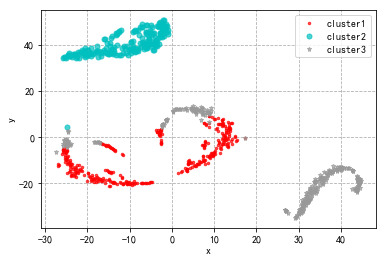

In [84]:
# 流行学习聚类结果可视化
plot(useful_feature, Bayesian_Gaussian_result, title='基于贝叶斯高斯混合模型的股票聚类结果可视化分析')

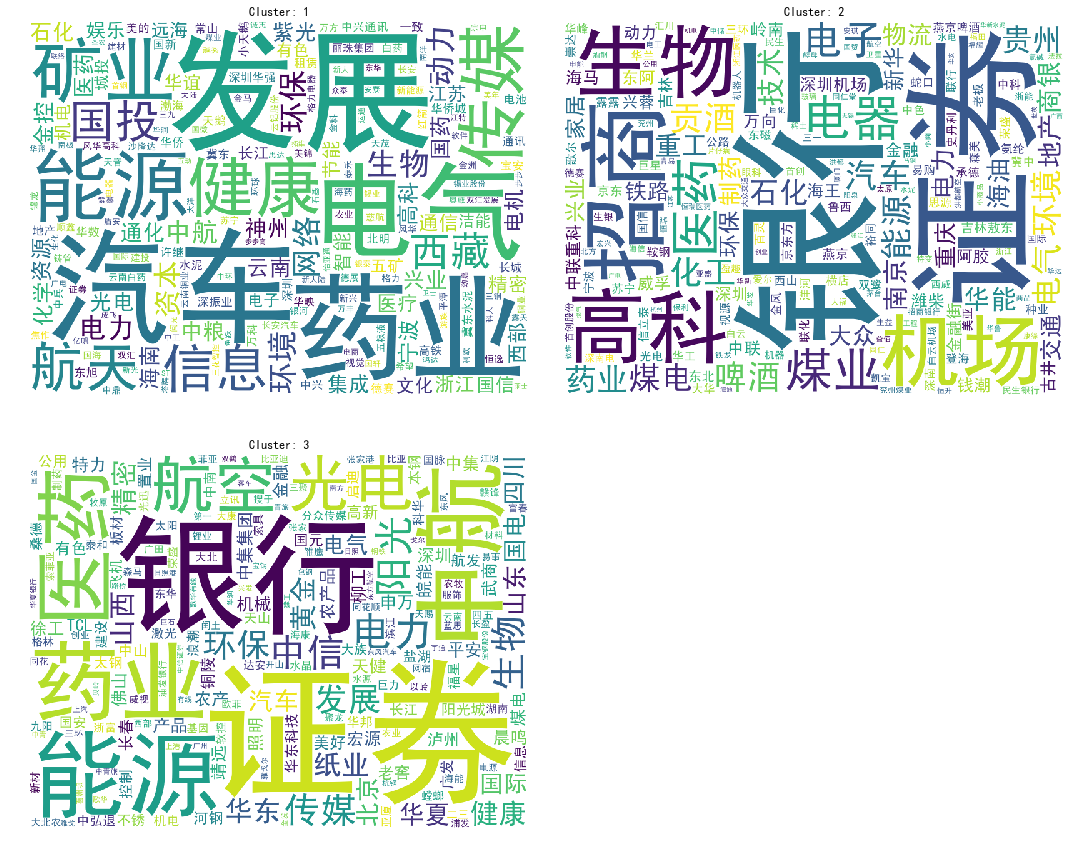

In [85]:
plot_wordcloud(Bayesian_Gaussian_result, n, 'shares_name', ID_name)

### AHC聚类 

In [86]:
def AHC_cluser(useful_feature, data_id, data_score, important_features, n, cv_type):
    model = AgglomerativeClustering(n_clusters=n, linkage=cv_type)
    model.fit(useful_feature)
    labels = model.labels_
    score_sil = metrics.silhouette_score(useful_feature, labels, metric='euclidean')
    print("当聚为%d簇时，层次分析法轮廓系数Silhouette Coefficient为：%f" % (n, score_sil))             # 计算轮廓系数
    score_cal = metrics.calinski_harabaz_score(useful_feature, labels) 
    print("当聚为%d簇时，层次分析法轮廓系数Calinski-Harabaz Index为：%f" % (n, score_cal))
    score_dbi = metrics.davies_bouldin_score(useful_feature, labels)                                     # DBI值越小越好（说明分散程度低）
    print("当聚为%d簇时，层次分析法 Davies-Bouldin分数值为：%f" % (n, score_dbi))
    AHC_result = pd.concat([useful_feature, pd.Series(labels, index=useful_feature.index)], axis=1)
    AHC_result.columns = list(useful_feature.columns) + ['label']
    AHC_result.insert(0, 'eventid', data_id)
    AHC_result['overall'] = data_score
    center_overall_sum = {}
    for i in range(n):
        temp = (AHC_result[AHC_result.label == i])['overall'].sum()
        key_word = '第' + str(i) + '类'
        center_overall_sum[key_word] = temp
    center_overall_sum = sorted(center_overall_sum.items(), key = lambda x:x[1], reverse = True)
    Old_label = []
    New_label = []
    num = 0
    for i in center_overall_sum:
        num += 1
        Old_label.append(int(i[0][1]))
        New_label.append(num)
    label = list(deepcopy(AHC_result['label']))
    temp = []
    for i in range(len(label)):
        for j in range(n):
            if label[i] == Old_label[j]:
                temp.append(New_label[j])
    AHC_result.drop('label', axis=1, inplace=True)
    AHC_result['label'] = temp
    return AHC_result

### 大板块AHC聚类结果 

In [87]:
start = time.clock()
AHC_result = AHC_cluser(useful_feature, data_id, data_score, important_features, n, 'ward')
end = time.clock()
print('AHC running time', end-start)

当聚为3簇时，层次分析法轮廓系数Silhouette Coefficient为：0.554377
当聚为3簇时，层次分析法轮廓系数Calinski-Harabaz Index为：1656.525374
当聚为3簇时，层次分析法 Davies-Bouldin分数值为：0.752162
AHC running time 0.07448828825202014


In [88]:
AHC_result.head(10)

eventid       var  diff_var   RSV9max   RSV9var  RSV30max  RSV30var  \
0  000001.SZ  0.165104 -0.367831  1.026503  3.173860  0.472816  1.508373   
1  000002.SZ  0.381317 -0.185292  1.174640  5.217246  0.055200  2.122027   
2  000006.SZ  0.191375 -0.324197  0.065349  4.071067  0.046819  1.893419   
3  000008.SZ  0.244449 -0.386268  1.231728  4.881856  0.503372  1.916986   
4  000009.SZ  0.180002 -0.277979  1.168130  4.129470  0.500822  1.907192   
5  000012.SZ  0.157481 -0.302676  1.162721  3.918376  0.067472 -0.206535   
6  000021.SZ  0.184877 -0.276474  1.279452  4.796660  0.056683 -0.207344   
7  000025.SZ  0.543192  0.061585  0.098247  4.174883  0.051163 -0.213829   
8  000027.SZ  0.136515 -0.364537  0.102516  2.051805  0.050794  1.292779   
9  000028.SZ  0.508959  0.036337  0.078969  6.713402  0.033123  2.405836   

   RSV30std  RSV90max  RSV90var  RSV90std   overall  label  
0  0.425390  0.060584 -0.401877 -0.152464  0.000287      1  
1  0.598445  0.056588  0.689324  0.261523  0.002134      1  
2  0.533976  0.039153  0.680125  0.258035  0.000859      1  
3  0.540622  0.052729 -0.373798 -0.141809  0.000604      1  
4  0.537860  0.059084 -0.424003 -0.160859  0.000530      1  
5 -0.058230  0.044698 -0.413379 -0.156828  0.000275      3  
6 -0.058459  0.048683 -0.386565 -0.146653  0.000360      3  
7 -0.060287  0.035566 -0.400743 -0.152033  0.001832      3  
8  0.364591  0.047315 -0.411484 -0.156109  0.000224      1  
9  0.678481  0.049802  0.697036  0.264447  0.008570      1

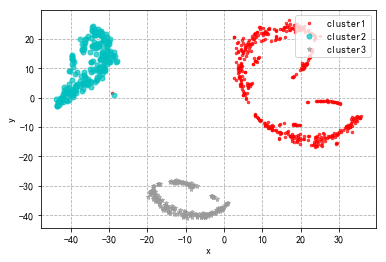

In [89]:
# 流行学习聚类结果可视化
plot(useful_feature, AHC_result, title='基于层次分析法的股票聚类结果可视化分析')

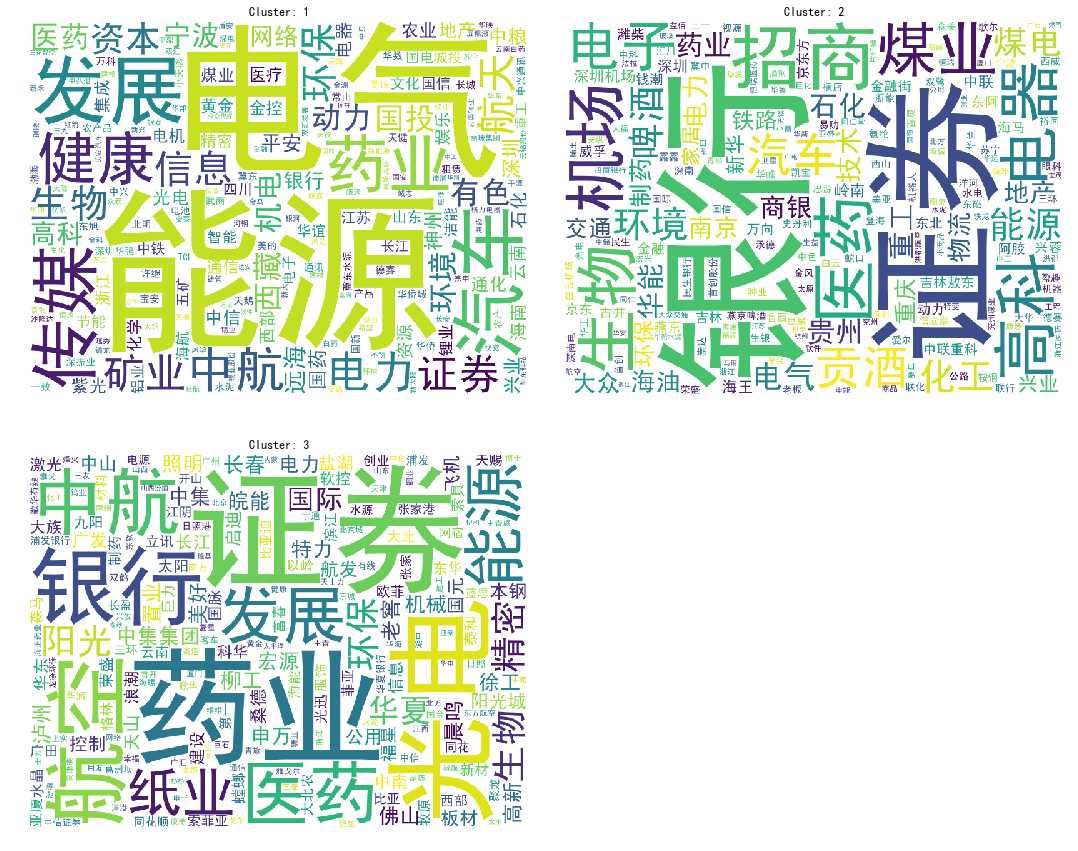

In [90]:
plot_wordcloud(AHC_result, n, 'shares_name', ID_name)

### 密度聚类之DBSCAN

In [91]:
def DBSCAN_cluser(useful_feature, data_id, data_score, important_features, eps, samples):
    model = DBSCAN(eps=eps, min_samples=samples)
    model.fit(useful_feature)
    labels = model.labels_
    n = len(list(set(labels)))
    score_sil = metrics.silhouette_score(useful_feature, labels, metric='euclidean')
    print("当聚为%d簇时，层次分析法轮廓系数Silhouette Coefficient为：%f" % (n, score_sil))             # 计算轮廓系数
    score_cal = metrics.calinski_harabaz_score(useful_feature, labels) 
    print("当聚为%d簇时，层次分析法轮廓系数Calinski-Harabaz Index为：%f" % (n, score_cal))
    score_dbi = metrics.davies_bouldin_score(useful_feature, labels)                                     # DBI值越小越好（说明分散程度低）
    print("当聚为%d簇时，层次分析法 Davies-Bouldin分数值为：%f" % (n, score_dbi))
    DBSCAN_result = pd.concat([useful_feature, pd.Series(labels, index=useful_feature.index)], axis=1)
    DBSCAN_result.columns = list(useful_feature.columns) + ['label']
    DBSCAN_result.insert(0, 'eventid', data_id)
    DBSCAN_result['overall'] = data_score
    DBSCAN_result['label2'] = DBSCAN_result['label']
    DBSCAN_result.loc[DBSCAN_result['label']==-1, 'label2'] = 2                                                 # 将-1替换为3
    DBSCAN_result.drop('label',axis=1, inplace=True)
    center_overall_sum = {}
    for i in range(n):
        temp = (DBSCAN_result[DBSCAN_result.label2 == i])['overall'].sum()
        key_word = '第' + str(i) + '类'
        center_overall_sum[key_word] = temp
    center_overall_sum = sorted(center_overall_sum.items(), key = lambda x:x[1], reverse = True)
    Old_label = []
    New_label = []
    num = 0
    for i in center_overall_sum:
        num += 1
        Old_label.append(int(i[0][1]))
        New_label.append(num)
    label = list(deepcopy(DBSCAN_result['label2']))
    temp = []
    for i in range(len(label)):
        for j in range(n):
            if label[i] == Old_label[j]:
                temp.append(New_label[j])
    DBSCAN_result.drop('label2', axis=1, inplace=True)
    DBSCAN_result['label'] = temp
    return DBSCAN_result

###  大板块DBSCAN聚类结果

In [92]:
start = time.clock()
DBSCAN_result = DBSCAN_cluser(useful_feature, data_id, data_score, important_features, 0.992, 91)
end = time.clock()
print('DBSCAN running time', end-start)

当聚为3簇时，层次分析法轮廓系数Silhouette Coefficient为：0.482321
当聚为3簇时，层次分析法轮廓系数Calinski-Harabaz Index为：1259.954948
当聚为3簇时，层次分析法 Davies-Bouldin分数值为：1.244636
DBSCAN running time 0.10740805214993543


In [93]:
DBSCAN_result.head(10)

eventid       var  diff_var   RSV9max   RSV9var  RSV30max  RSV30var  \
0  000001.SZ  0.165104 -0.367831  1.026503  3.173860  0.472816  1.508373   
1  000002.SZ  0.381317 -0.185292  1.174640  5.217246  0.055200  2.122027   
2  000006.SZ  0.191375 -0.324197  0.065349  4.071067  0.046819  1.893419   
3  000008.SZ  0.244449 -0.386268  1.231728  4.881856  0.503372  1.916986   
4  000009.SZ  0.180002 -0.277979  1.168130  4.129470  0.500822  1.907192   
5  000012.SZ  0.157481 -0.302676  1.162721  3.918376  0.067472 -0.206535   
6  000021.SZ  0.184877 -0.276474  1.279452  4.796660  0.056683 -0.207344   
7  000025.SZ  0.543192  0.061585  0.098247  4.174883  0.051163 -0.213829   
8  000027.SZ  0.136515 -0.364537  0.102516  2.051805  0.050794  1.292779   
9  000028.SZ  0.508959  0.036337  0.078969  6.713402  0.033123  2.405836   

   RSV30std  RSV90max  RSV90var  RSV90std   overall  label  
0  0.425390  0.060584 -0.401877 -0.152464  0.000287      1  
1  0.598445  0.056588  0.689324  0.261523  0.002134      1  
2  0.533976  0.039153  0.680125  0.258035  0.000859      2  
3  0.540622  0.052729 -0.373798 -0.141809  0.000604      1  
4  0.537860  0.059084 -0.424003 -0.160859  0.000530      1  
5 -0.058230  0.044698 -0.413379 -0.156828  0.000275      2  
6 -0.058459  0.048683 -0.386565 -0.146653  0.000360      2  
7 -0.060287  0.035566 -0.400743 -0.152033  0.001832      2  
8  0.364591  0.047315 -0.411484 -0.156109  0.000224      2  
9  0.678481  0.049802  0.697036  0.264447  0.008570      2

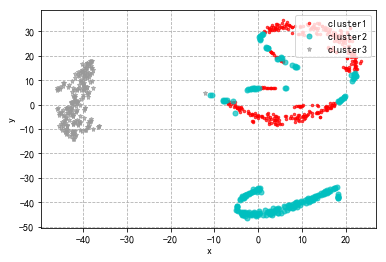

In [94]:
# 流行学习聚类结果可视化
plot(useful_feature, DBSCAN_result, title='基于DBSCAN的股票聚类结果可视化分析')

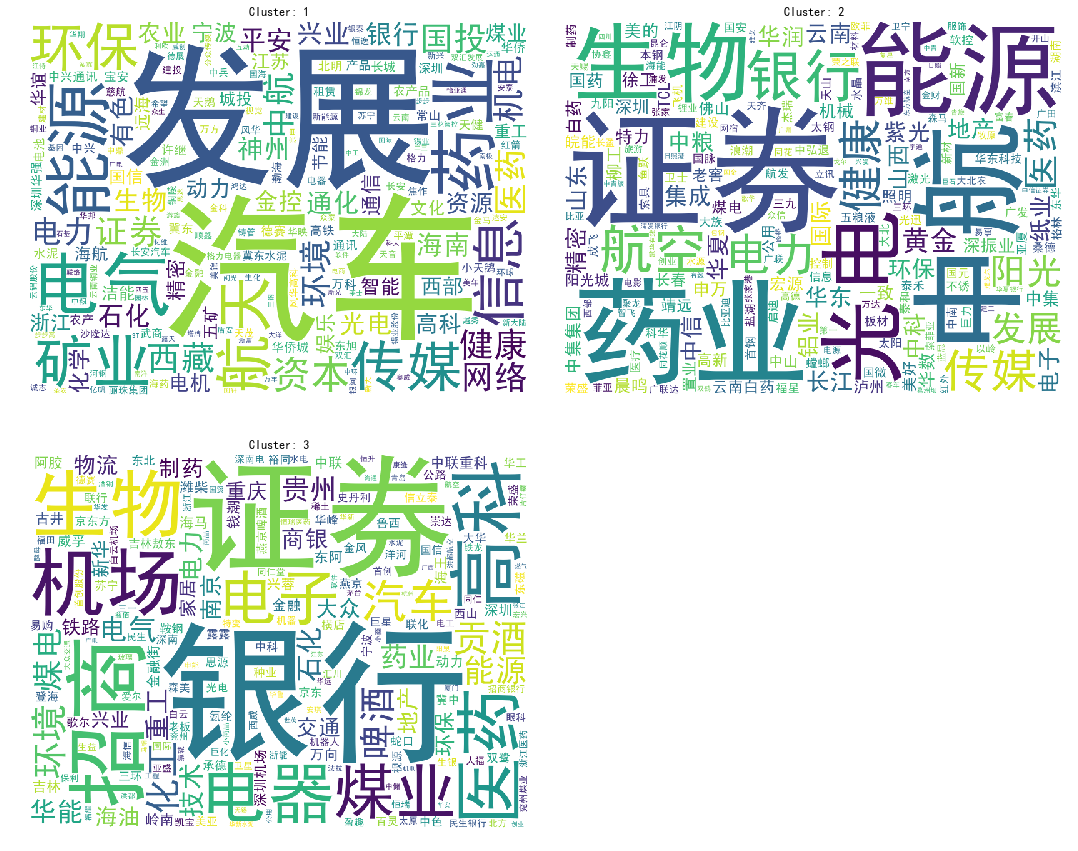

In [95]:
plot_wordcloud(DBSCAN_result, n, 'shares_name', ID_name)

### KFCM聚类 

In [96]:
def normalise_U(U):
    for i in range(0, len(U)):
        maximum = max(U[i])
        for j in range(0, len(U[0])):
            if U[i][j] != maximum:
                U[i][j] = 0
            else:
                U[i][j] = 1
    return U
def init_U(kmeans_result):
    encoder = OneHotEncoder()
    U = encoder.fit_transform(kmeans_result['label'].values.reshape(-1,1))
    U = U.toarray()
    U.astype(float)
    return U
def CMeans_cluser(useful_feature, n, data_id, data_score, __m=2.0):
    data_columns = useful_feature.columns
    KFCM_result = np.matrix(useful_feature)
    KFCM_result = KFCM_result.T
    #U_ = np.matrix(U_)
    #U_ = U_.T
    center, u, u0, d, jm, p, fpc = cmeans(KFCM_result, m=__m, c=n, error=0.0000001, maxiter=100, init=None)
    # print('end KFCM')
    u = u.T
    final_location = normalise_U(u)
    label = []
    for i in final_location:
        i = list(i)
        temp = i.index(1)
        label.append(temp)
    score_sil = metrics.silhouette_score(useful_feature, label, metric='euclidean')
    print("当聚为%d簇时，KFCM轮廓系数Silhouette Coefficient为：%f" % (n, score_sil))             # 计算轮廓系数
    score_cal = metrics.calinski_harabaz_score(useful_feature, label) 
    print("当聚为%d簇时，KFCM轮廓系数Calinski-Harabaz Index为：%f" % (n, score_cal))
    score_dbi = metrics.davies_bouldin_score(useful_feature, label)                             # DBI值越小越好（说明分散程度低）
    print("当聚为%d簇时，KFCM Davies-Bouldin分数值为：%f" % (n, score_dbi))
    KFCM_result = KFCM_result.T
    KFCM_result = pd.DataFrame(KFCM_result)
    KFCM_result.columns = data_columns
    KFCM_result['label'] = label
    KFCM_result['overall'] = data_score
    center_overall_sum = {}
    for i in range(n):
        temp = (KFCM_result[KFCM_result.label == i])['overall'].sum()
        key_word = '第' + str(i) + '类'
        center_overall_sum[key_word] = temp
    center_overall_sum = sorted(center_overall_sum.items(), key = lambda x:x[1], reverse=True)
    Old_label = []
    New_label = []
    num = 0
    for i in center_overall_sum:
        num += 1
        Old_label.append(int(i[0][1]))
        New_label.append(num)
    label = list(deepcopy(KFCM_result['label']))
    temp = []
    for i in range(len(label)):
        for j in range(n):
            if label[i] == Old_label[j]:
                temp.append(New_label[j])
    KFCM_result.drop('label', axis=1, inplace=True)
    KFCM_result['label'] = temp
    KFCM_result.insert(0, 'eventid', data_id)
    return KFCM_result

### 大板块KFCM聚类结果 

In [97]:
U = init_U(kmeans_result)
start = time.clock()
#useful_feature.drop('var', axis=1, inplace=True)
#useful_feature.drop('diff_var', axis=1, inplace=True)
KFCM_result = CMeans_cluser(useful_feature, n, data_id, data_score,  __m=m)
end = time.clock()
print('KFCM running time', end-start)

当聚为3簇时，KFCM轮廓系数Silhouette Coefficient为：0.553890
当聚为3簇时，KFCM轮廓系数Calinski-Harabaz Index为：1730.488254
当聚为3簇时，KFCM Davies-Bouldin分数值为：0.758144
KFCM running time 0.07235550629196297


In [98]:
KFCM_result.head(10)

eventid       var  diff_var   RSV9max   RSV9var  RSV30max  RSV30var  \
0  000001.SZ  0.165104 -0.367831  1.026503  3.173860  0.472816  1.508373   
1  000002.SZ  0.381317 -0.185292  1.174640  5.217246  0.055200  2.122027   
2  000006.SZ  0.191375 -0.324197  0.065349  4.071067  0.046819  1.893419   
3  000008.SZ  0.244449 -0.386268  1.231728  4.881856  0.503372  1.916986   
4  000009.SZ  0.180002 -0.277979  1.168130  4.129470  0.500822  1.907192   
5  000012.SZ  0.157481 -0.302676  1.162721  3.918376  0.067472 -0.206535   
6  000021.SZ  0.184877 -0.276474  1.279452  4.796660  0.056683 -0.207344   
7  000025.SZ  0.543192  0.061585  0.098247  4.174883  0.051163 -0.213829   
8  000027.SZ  0.136515 -0.364537  0.102516  2.051805  0.050794  1.292779   
9  000028.SZ  0.508959  0.036337  0.078969  6.713402  0.033123  2.405836   

   RSV30std  RSV90max  RSV90var  RSV90std   overall  label  
0  0.425390  0.060584 -0.401877 -0.152464  0.000287      1  
1  0.598445  0.056588  0.689324  0.261523  0.002134      1  
2  0.533976  0.039153  0.680125  0.258035  0.000859      1  
3  0.540622  0.052729 -0.373798 -0.141809  0.000604      1  
4  0.537860  0.059084 -0.424003 -0.160859  0.000530      1  
5 -0.058230  0.044698 -0.413379 -0.156828  0.000275      3  
6 -0.058459  0.048683 -0.386565 -0.146653  0.000360      3  
7 -0.060287  0.035566 -0.400743 -0.152033  0.001832      3  
8  0.364591  0.047315 -0.411484 -0.156109  0.000224      2  
9  0.678481  0.049802  0.697036  0.264447  0.008570      1

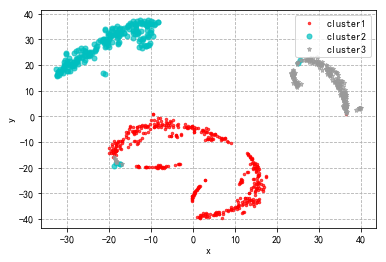

In [99]:
# 流行学习聚类结果可视化
plot(useful_feature, KFCM_result, title='基于FCM的股票聚类结果可视化分析')

### 绘制词云 

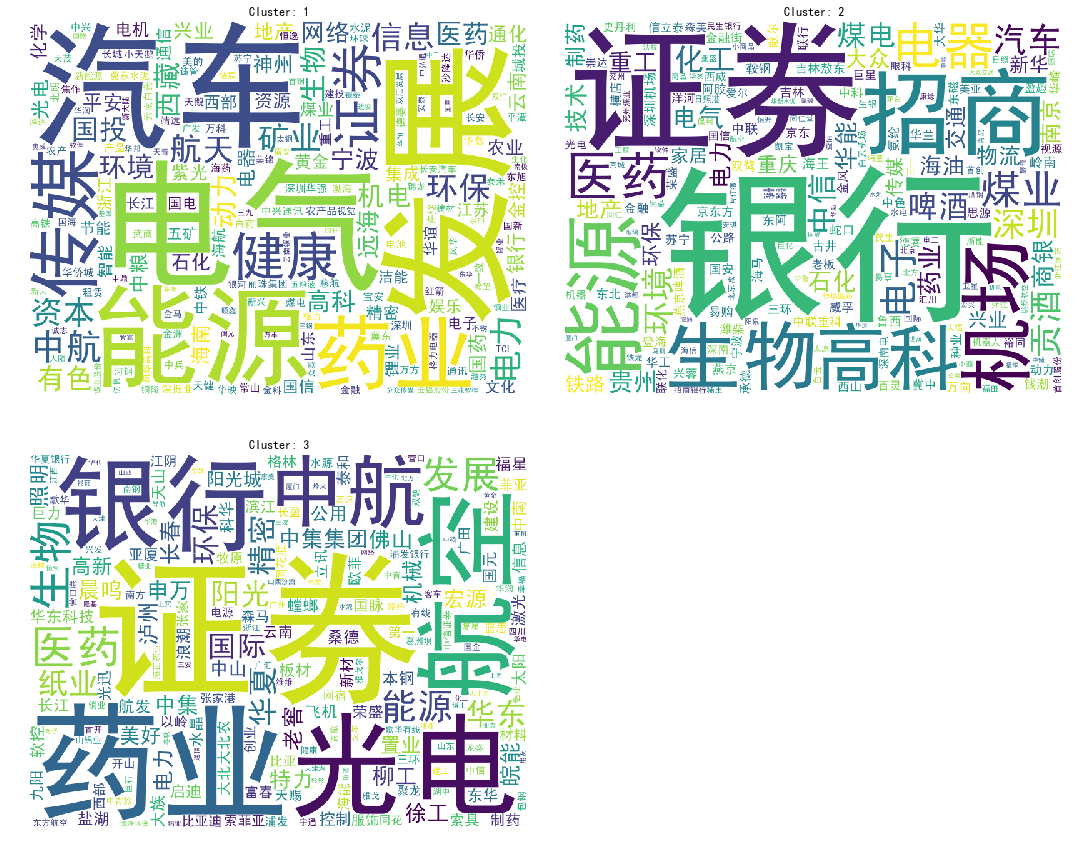

In [100]:
plot_wordcloud(KFCM_result, n, 'shares_name', ID_name)

# 大板块最终的划分结果

In [101]:
def big_plate_conclusion(KFCM_result, original, n):
    final = pd.DataFrame(columns = ["id"])
    final['id'] = list(deepcopy(KFCM_result['eventid']))
    final['mean'] = list(deepcopy(original['mean']))
    final['std'] = list(deepcopy(original['std']))
    final['label'] = list(deepcopy(KFCM_result['label']))
    cort_mean = []
    cort_std = []
    cort_id = []
    for i in range(1, n+1):
        label_cou = final[final['label'].isin([i])]
        mean = list(deepcopy(label_cou['mean']))
        mean = sum(mean) / len(mean)
        std = list(deepcopy(label_cou['std']))
        std = sum(std) / len(std)
        id_ = list(deepcopy(label_cou['id']))
        cort_mean.append(mean)
        cort_std.append(std)
        cort_id.append(id_)
    cort_id = np.asarray(cort_id)
    sub_label = list(np.arange(1, n+1))
    big_plate = pd.DataFrame({'mean': cort_mean, 'std': cort_std, 'id': cort_id, 'label': sub_label})
    return big_plate

#### 大板块结果保存 

In [102]:
big_plate = big_plate_conclusion(KFCM_result, original, n)
big_plate.to_csv('../result/big_plate.csv', index=False)

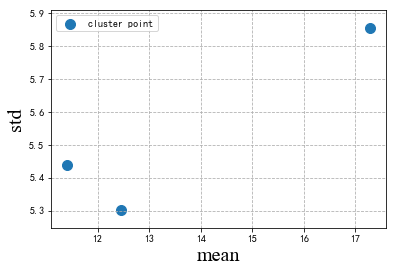

0.917859009990314


In [103]:
# 大板块均值和方差之间的关系，可以观察到其为正相关，即高风险，高回报
plate_show(big_plate)

# 小板块最终的划分结果

In [104]:
def sub_dataframe(old_data, KFCM_result, n):
    old_data['label'] = list(deepcopy(KFCM_result['label']))
    label_cou = []
    for i in range(1, n+1):
        label_cou.append(old_data[old_data['label'].isin([i])])
    return label_cou

In [105]:
sub_data = sub_dataframe(old_data, KFCM_result, n)

In [106]:
def buid_submodel(data, sub_n, m):
    data_id = list(deepcopy(data['eventid']))
    data_score = list(deepcopy(data['overall']))
    data.drop('eventid', axis=1, inplace=True)
    data.drop('overall', axis=1, inplace=True)
    data.drop('label', axis=1, inplace=True)
    useful_feature, important_features = deal_related(data)
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV90std')
    useful_feature = boxcox_trans(useful_feature, feature_name='var')
    useful_feature = boxcox_trans(useful_feature, feature_name='diff_var')
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV9max')
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV9var')
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV30max')
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV30var')
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV30std')
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV90max')
    useful_feature = boxcox_trans(useful_feature, feature_name='RSV90var')
    sub_KFCM_result = CMeans_cluser(useful_feature, sub_n, data_id, data_score,  __m=m)
    return sub_KFCM_result

In [107]:
def small_plate_conclusion(cluser, original_data, n, k):
    final = pd.DataFrame(columns = ["id"])
    final['id'] = list(deepcopy(cluser['eventid']))
    final['mean'] = list(deepcopy(original_data['mean']))
    final['std'] = list(deepcopy(original_data['std']))
    final['label'] = list(deepcopy(cluser['label']))
    cort_mean = []
    cort_std = []
    cort_id = []
    for i in range(1, n+1):
        label_cou = final[final['label'].isin([i])]
        mean = list(deepcopy(label_cou['mean']))
        mean = sum(mean) / len(mean)
        std = list(deepcopy(label_cou['std']))
        std = sum(std) / len(std)
        id_ = list(deepcopy(label_cou['id']))
        cort_mean.append(mean)
        cort_std.append(std)
        cort_id.append(id_)
    cort_id = np.asarray(cort_id)
    sub_label = list(np.arange(1, n+1))
    upper_label = []
    for i in range(len(cort_mean)):
        upper_label.append(k+1)
    small_plate = pd.DataFrame({'mean': cort_mean, 'std': cort_std, 'id': cort_id, 'sub_label': sub_label, 'upper_label': upper_label})
    return small_plate

#### 小板块结果保存 

In [108]:
sub = []
for i in range(n):
    sub_KFCM_result = buid_submodel(sub_data[i], sub_n, sub_m[i])
    sub.append(sub_KFCM_result)
sub_orig = sub_dataframe(original_use_for_sub, KFCM_result, n)
sub_final = []
for i in range(n):
    sub_final.append(small_plate_conclusion(sub[i], sub_orig[i], sub_n, i))
for i in range(n):
    sub = sub_final[i]
    file_load = '../result/num' + str(i+1) + 'big_plate_sub.csv'
    sub.to_csv(file_load, index=False)

-0.06721655226376522
0.005100191664811859
-0.016412526201986057
0.32288777440162647
-4.508297742853689
0.217448162343688
0.10398927493087626
0.2079319870289395
-0.28376169793861933
-0.03360799865644105
当聚为10簇时，KFCM轮廓系数Silhouette Coefficient为：0.333701
当聚为10簇时，KFCM轮廓系数Calinski-Harabaz Index为：604.669741
当聚为10簇时，KFCM Davies-Bouldin分数值为：0.979841
-0.6309914843864435
-0.12119840067445618
-0.08920842021415579
-0.885786700924721
-1.832190978666735
-1.2105008615433595
-1.3212410117888689
-2.6566100240931845
-0.585529365984947
-0.3144366527265022
当聚为10簇时，KFCM轮廓系数Silhouette Coefficient为：0.218849
当聚为10簇时，KFCM轮廓系数Calinski-Harabaz Index为：115.273233
当聚为10簇时，KFCM Davies-Bouldin分数值为：1.137628
7.407555314843077
-0.05178589734012315
-0.03399243287703023
0.21809160187566765
-5.005347653227021
-1.3763370877331553
-1.6006111850945257
-3.2032375539547426
-1.43005686316073
3.7063491002430355
当聚为10簇时，KFCM轮廓系数Silhouette Coefficient为：0.504440
当聚为10簇时，KFCM轮廓系数Calinski-Harabaz Index为：948.709057
当聚为10簇时，KFCM Davies-B

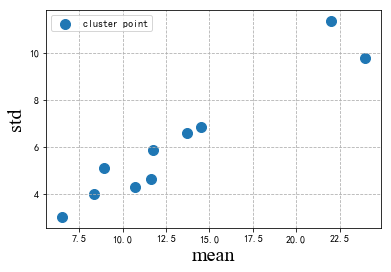

0.9575732677799208


In [109]:
# 大板块0中10个小板块均值和方差之间的关系，可以观察到其为正相关，即高风险，高回报
plate_show(sub_final[0])

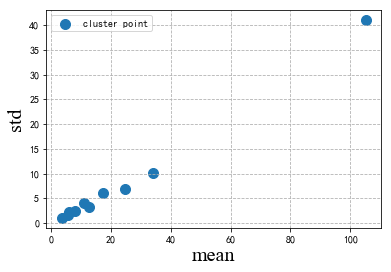

0.9952766332858666


In [110]:
# 大板块1中10个小板块均值和方差之间的关系，可以观察到其为正相关，即高风险，高回报
plate_show(sub_final[1])

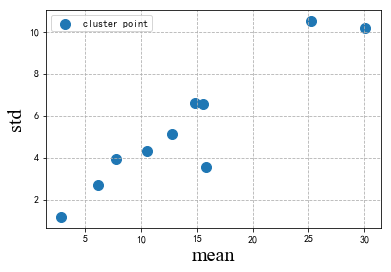

0.9365771919815582


In [111]:
# 大板块2中10个小板块均值和方差之间的关系，可以观察到其为正相关，即高风险，高回报
plate_show(sub_final[2])

In [112]:
# 大板块3中10个小板块均值和方差之间的关系，可以观察到其为正相关，即高风险，高回报
# plate_show(sub_final[3])

# 按照传统方法进行板块划分的结果

In [113]:
def menu_score(data):
    menu = pd.read_excel('../result/行业分类.xlsx')
    menu_label = list(deepcopy(menu['label']))
    score_sil = metrics.silhouette_score(data, menu_label, metric='euclidean')
    print("行业划分下，KFCM轮廓系数Silhouette Coefficient为：%f" % (-score_sil))             # 计算轮廓系数
    score_cal = metrics.calinski_harabaz_score(data, menu_label) 
    print("行业划分下，KFCM轮廓系数Calinski-Harabaz Index为：%f" % (score_cal))

In [114]:
menu_score(useful_feature)

行业划分下，KFCM轮廓系数Silhouette Coefficient为：0.349917
行业划分下，KFCM轮廓系数Calinski-Harabaz Index为：5.656110
